### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_0/'
summaries_path = cur_dir + 'summaries_2_0/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 0
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams


old_new_ratio_list = [1.0] + list(range(1, t + 1))

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        old_new_ratio_list=old_new_ratio_list)

sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.52499998], average train loss: 1.356765, average train accuracy: 0.549805
epoch: 2, iter: 0/8, validation accuracies: [0.77499998], average train loss: 0.800086, average train accuracy: 0.626953
epoch: 3, iter: 0/8, validation accuracies: [0.5], average train loss: 0.652563, average train accuracy: 0.715820
epoch: 4, iter: 0/8, validation accuracies: [0.875], average train loss: 0.580435, average train accuracy: 0.741211
epoch: 5, iter: 0/8, validation accuracies: [0.85000002], average train loss: 0.542295, average train accuracy: 0.759766
epoch: 6, iter: 0/8, validation accuracies: [0.82499999], average train loss: 0.500176, average train accuracy: 0.765625
epoch: 7, iter: 0/8, validation accuracies: [0.85000002], average train loss: 0.486011, average train accuracy: 0.800781
epo

epoch: 66, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.073024, average train accuracy: 0.968750
epoch: 67, iter: 0/8, validation accuracies: [0.875], average train loss: 0.062043, average train accuracy: 0.971680
epoch: 68, iter: 0/8, validation accuracies: [0.875], average train loss: 0.048676, average train accuracy: 0.982422
epoch: 69, iter: 0/8, validation accuracies: [0.875], average train loss: 0.051834, average train accuracy: 0.976562
epoch: 70, iter: 0/8, validation accuracies: [0.89999998], average train loss: 0.051349, average train accuracy: 0.986328
epochs: 70.000000, final train loss: 0.052675, validation accuracies: [0.89999998]
best epochs: 28.000000, best_avg: 0.950000, validation accuracies: [0.94999999]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.44523072242736816
saving penultimat

epoch: 49, iter: 0/8, validation accuracies: [0.625      0.72500002], average train loss: 0.577958, average train accuracy: 0.769531
epoch: 50, iter: 0/8, validation accuracies: [0.72500002 0.67500001], average train loss: 0.611411, average train accuracy: 0.754883
epoch: 50, iter: 0/8, loss: 0.554521, accuracy: 0.742188
epoch: 51, iter: 0/8, validation accuracies: [0.72500002 0.67500001], average train loss: 0.531560, average train accuracy: 0.792969
epoch: 52, iter: 0/8, validation accuracies: [0.72500002 0.75      ], average train loss: 0.532603, average train accuracy: 0.781250
epoch: 53, iter: 0/8, validation accuracies: [0.69999999 0.75      ], average train loss: 0.465995, average train accuracy: 0.825195
epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.77499998], average train loss: 0.443039, average train accuracy: 0.829102
epoch: 55, iter: 0/8, validation accuracies: [0.75 0.75], average train loss: 0.435368, average train accuracy: 0.833008
epoch: 56, iter: 0/8, va

epoch: 29, iter: 0/8, validation accuracies: [0.72500002 0.625      0.57499999], average train loss: 0.721490, average train accuracy: 0.711914
epoch: 30, iter: 0/8, validation accuracies: [0.60000002 0.175      0.67500001], average train loss: 0.751828, average train accuracy: 0.723633
epoch: 31, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.625     ], average train loss: 0.879698, average train accuracy: 0.658203
epoch: 32, iter: 0/8, validation accuracies: [0.67500001 0.55000001 0.64999998], average train loss: 0.740695, average train accuracy: 0.698242
epoch: 33, iter: 0/8, validation accuracies: [0.64999998 0.625      0.69999999], average train loss: 0.654850, average train accuracy: 0.752930
epoch: 34, iter: 0/8, validation accuracies: [0.69999999 0.82499999 0.60000002], average train loss: 0.704234, average train accuracy: 0.719727
epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.55000001 0.67500001], average train loss: 0.630273, average train accuracy: 0

epoch: 7, iter: 0/8, validation accuracies: [0.625      0.60000002 0.2        0.5       ], average train loss: 1.246976, average train accuracy: 0.526367
epoch: 8, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.22499999 0.44999999], average train loss: 1.176535, average train accuracy: 0.552734
epoch: 9, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.30000001 0.625     ], average train loss: 1.196416, average train accuracy: 0.553711
epoch: 10, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.5        0.60000002], average train loss: 1.166183, average train accuracy: 0.547852
epoch: 11, iter: 0/8, validation accuracies: [0.85000002 0.27500001 0.57499999 0.44999999], average train loss: 1.074604, average train accuracy: 0.601562
epoch: 12, iter: 0/8, validation accuracies: [0.64999998 0.625      0.57499999 0.60000002], average train loss: 1.027157, average train accuracy: 0.618164
epoch: 12, iter: 4/8, loss: 1.284784, accuracy: 0.476562
epoch: 13, iter:

epoch: 59, iter: 0/8, validation accuracies: [0.77499998 0.64999998 0.625      0.80000001], average train loss: 0.464834, average train accuracy: 0.825195
epoch: 60, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.64999998 0.82499999], average train loss: 0.465312, average train accuracy: 0.836914
epoch: 61, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.67500001 0.82499999], average train loss: 0.454490, average train accuracy: 0.833984
epoch: 62, iter: 0/8, validation accuracies: [0.75       0.60000002 0.625      0.80000001], average train loss: 0.437200, average train accuracy: 0.834961
epoch: 62, iter: 4/8, loss: 0.473820, accuracy: 0.843750
epoch: 63, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.57499999 0.82499999], average train loss: 0.464223, average train accuracy: 0.833984
epoch: 64, iter: 0/8, validation accuracies: [0.82499999 0.69999999 0.60000002 0.82499999], average train loss: 0.423017, average train accuracy: 0.852539
epoch: 65, it

epoch: 32, iter: 0/8, validation accuracies: [0.64999998 0.57499999 0.55000001 0.82499999 0.64999998], average train loss: 0.702431, average train accuracy: 0.732422
epoch: 33, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.57499999 0.69999999 0.82499999], average train loss: 0.729994, average train accuracy: 0.729492
epoch: 34, iter: 0/8, validation accuracies: [0.72500002 0.60000002 0.72500002 0.72500002 0.80000001], average train loss: 0.726852, average train accuracy: 0.720703
epoch: 35, iter: 0/8, validation accuracies: [0.875      0.55000001 0.64999998 0.72500002 0.60000002], average train loss: 0.680340, average train accuracy: 0.757812
epoch: 36, iter: 0/8, validation accuracies: [0.5        0.52499998 0.80000001 0.52499998 0.80000001], average train loss: 0.704600, average train accuracy: 0.748047
epoch: 37, iter: 0/8, validation accuracies: [0.67500001 0.64999998 0.44999999 0.77499998 0.60000002], average train loss: 0.728099, average train accuracy: 0.742188
epoc

epoch: 3, iter: 0/8, validation accuracies: [0.69999999 0.32499999 0.15000001 0.32499999 0.25       0.625     ], average train loss: 1.575541, average train accuracy: 0.461914
epoch: 4, iter: 0/8, validation accuracies: [0.64999998 0.375      0.175      0.15000001 0.34999999 0.60000002], average train loss: 1.419296, average train accuracy: 0.500000
epoch: 5, iter: 0/8, validation accuracies: [0.77499998 0.42500001 0.30000001 0.44999999 0.22499999 0.60000002], average train loss: 1.312664, average train accuracy: 0.506836
epoch: 6, iter: 0/8, validation accuracies: [0.80000001 0.1        0.34999999 0.22499999 0.47499999 0.30000001], average train loss: 1.308700, average train accuracy: 0.551758
epoch: 7, iter: 0/8, validation accuracies: [0.625      0.40000001 0.44999999 0.42500001 0.375      0.77499998], average train loss: 1.248546, average train accuracy: 0.541992
epoch: 8, iter: 0/8, validation accuracies: [0.80000001 0.40000001 0.47499999 0.55000001 0.47499999 0.52499998], average

epoch: 49, iter: 0/8, validation accuracies: [0.69999999 0.60000002 0.40000001 0.72500002 0.67500001 0.67500001], average train loss: 0.635169, average train accuracy: 0.780273
epoch: 50, iter: 0/8, validation accuracies: [0.75       0.64999998 0.57499999 0.69999999 0.77499998 0.75      ], average train loss: 0.668395, average train accuracy: 0.750977
epoch: 50, iter: 0/8, loss: 0.586266, accuracy: 0.812500
epoch: 51, iter: 0/8, validation accuracies: [0.72500002 0.64999998 0.64999998 0.67500001 0.80000001 0.82499999], average train loss: 0.633895, average train accuracy: 0.777344
epoch: 52, iter: 0/8, validation accuracies: [0.75       0.64999998 0.72500002 0.69999999 0.75       0.82499999], average train loss: 0.560023, average train accuracy: 0.789062
epoch: 53, iter: 0/8, validation accuracies: [0.77499998 0.64999998 0.67500001 0.72500002 0.72500002 0.75      ], average train loss: 0.551627, average train accuracy: 0.805664
epoch: 54, iter: 0/8, validation accuracies: [0.75       0

epoch: 17, iter: 0/8, validation accuracies: [0.75       0.44999999 0.44999999 0.55000001 0.67500001 0.5
 0.47499999], average train loss: 1.003669, average train accuracy: 0.630859
epoch: 18, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.44999999 0.5        0.72500002 0.57499999
 0.5       ], average train loss: 1.012624, average train accuracy: 0.631836
epoch: 19, iter: 0/8, validation accuracies: [0.69999999 0.67500001 0.60000002 0.47499999 0.67500001 0.625
 0.40000001], average train loss: 0.960137, average train accuracy: 0.652344
epoch: 20, iter: 0/8, validation accuracies: [0.375      0.42500001 0.64999998 0.72500002 0.64999998 0.625
 0.52499998], average train loss: 0.966376, average train accuracy: 0.663086
epoch: 21, iter: 0/8, validation accuracies: [0.375      0.57499999 0.625      0.67500001 0.67500001 0.75
 0.55000001], average train loss: 0.956369, average train accuracy: 0.657227
epoch: 22, iter: 0/8, validation accuracies: [0.57499999 0.32499999 0.57499999

epoch: 60, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.75       0.67500001 0.77499998 0.72500002
 0.75      ], average train loss: 0.599027, average train accuracy: 0.793945
epoch: 61, iter: 0/8, validation accuracies: [0.77499998 0.64999998 0.77499998 0.625      0.75       0.72500002
 0.69999999], average train loss: 0.586930, average train accuracy: 0.791992
epoch: 62, iter: 0/8, validation accuracies: [0.64999998 0.69999999 0.77499998 0.72500002 0.77499998 0.75
 0.75      ], average train loss: 0.584998, average train accuracy: 0.808594
epoch: 62, iter: 4/8, loss: 0.405834, accuracy: 0.851562
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.69999999 0.77499998 0.77499998 0.82499999
 0.77499998], average train loss: 0.543620, average train accuracy: 0.810547
epoch: 64, iter: 0/8, validation accuracies: [0.625      0.69999999 0.72500002 0.77499998 0.75       0.82499999
 0.77499998], average train loss: 0.499003, average train accuracy: 0.816406
epoc

epoch: 26, iter: 0/8, validation accuracies: [0.5        0.625      0.64999998 0.60000002 0.80000001 0.72500002
 0.47499999 0.625     ], average train loss: 0.901223, average train accuracy: 0.684570
epoch: 27, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.375      0.64999998 0.57499999 0.67500001
 0.55000001 0.625     ], average train loss: 0.911000, average train accuracy: 0.680664
epoch: 28, iter: 0/8, validation accuracies: [0.5        0.52499998 0.64999998 0.625      0.625      0.67500001
 0.69999999 0.64999998], average train loss: 0.876152, average train accuracy: 0.667969
epoch: 29, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.625      0.47499999 0.80000001 0.64999998
 0.32499999 0.47499999], average train loss: 0.890915, average train accuracy: 0.690430
epoch: 30, iter: 0/8, validation accuracies: [0.69999999 0.60000002 0.60000002 0.67500001 0.47499999 0.64999998
 0.57499999 0.57499999], average train loss: 0.962193, average train accuracy: 0.655273


epoch: 67, iter: 0/8, validation accuracies: [0.72500002 0.75       0.69999999 0.72500002 0.69999999 0.72500002
 0.64999998 0.55000001], average train loss: 0.576831, average train accuracy: 0.790039
epoch: 68, iter: 0/8, validation accuracies: [0.75       0.72500002 0.69999999 0.72500002 0.72500002 0.69999999
 0.625      0.57499999], average train loss: 0.578623, average train accuracy: 0.792969
epoch: 69, iter: 0/8, validation accuracies: [0.75       0.69999999 0.69999999 0.72500002 0.72500002 0.69999999
 0.625      0.55000001], average train loss: 0.609238, average train accuracy: 0.788086
epoch: 70, iter: 0/8, validation accuracies: [0.75       0.69999999 0.69999999 0.72500002 0.75       0.67500001
 0.64999998 0.5       ], average train loss: 0.564706, average train accuracy: 0.807617
epochs: 70.000000, final train loss: 0.677344, validation accuracies: [0.75       0.69999999 0.69999999 0.72500002 0.75       0.67500001
 0.64999998 0.5       ]
best epochs: 67.000000, best_avg: 0.690

epoch: 30, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.44999999 0.625      0.5        0.67500001
 0.44999999 0.44999999 0.52499998], average train loss: 0.969696, average train accuracy: 0.672852
epoch: 31, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.625      0.60000002 0.75       0.25
 0.60000002 0.40000001 0.47499999], average train loss: 0.908653, average train accuracy: 0.702148
epoch: 32, iter: 0/8, validation accuracies: [0.80000001 0.5        0.52499998 0.72500002 0.47499999 0.67500001
 0.52499998 0.25       0.47499999], average train loss: 0.883093, average train accuracy: 0.683594
epoch: 33, iter: 0/8, validation accuracies: [0.5        0.47499999 0.5        0.42500001 0.64999998 0.69999999
 0.55000001 0.40000001 0.55000001], average train loss: 0.918803, average train accuracy: 0.665039
epoch: 34, iter: 0/8, validation accuracies: [0.77499998 0.34999999 0.55000001 0.64999998 0.69999999 0.625
 0.44999999 0.32499999 0.625     ], average train loss:

epoch: 69, iter: 0/8, validation accuracies: [0.75       0.60000002 0.625      0.75       0.69999999 0.72500002
 0.72500002 0.47499999 0.69999999], average train loss: 0.561075, average train accuracy: 0.803711
epoch: 70, iter: 0/8, validation accuracies: [0.75       0.57499999 0.64999998 0.77499998 0.69999999 0.67500001
 0.72500002 0.5        0.69999999], average train loss: 0.595500, average train accuracy: 0.782227
epochs: 70.000000, final train loss: 0.671025, validation accuracies: [0.75       0.57499999 0.64999998 0.77499998 0.69999999 0.67500001
 0.72500002 0.5        0.69999999]
best epochs: 60.000000, best_avg: 0.680556, validation accuracies: [0.77499998 0.60000002 0.64999998 0.75       0.69999999 0.72500002
 0.75       0.44999999 0.72500002]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=8,task=8 at time step 560
calculating penultimate output...
time taken: %f 0.8442564010620117
saving penultim

epoch: 30, iter: 0/8, validation accuracies: [0.82499999 0.52499998 0.5        0.57499999 0.60000002 0.80000001
 0.5        0.40000001 0.72500002 0.69999999], average train loss: 0.873174, average train accuracy: 0.691406
epoch: 31, iter: 0/8, validation accuracies: [0.57499999 0.64999998 0.69999999 0.55000001 0.60000002 0.60000002
 0.55000001 0.40000001 0.55000001 0.69999999], average train loss: 0.895677, average train accuracy: 0.688477
epoch: 32, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.625      0.69999999 0.47499999 0.85000002
 0.52499998 0.44999999 0.625      0.67500001], average train loss: 0.905648, average train accuracy: 0.688477
epoch: 33, iter: 0/8, validation accuracies: [0.75       0.55000001 0.64999998 0.72500002 0.69999999 0.69999999
 0.67500001 0.32499999 0.5        0.72500002], average train loss: 0.967269, average train accuracy: 0.683594
epoch: 34, iter: 0/8, validation accuracies: [0.5        0.60000002 0.625      0.875      0.67500001 0.52499998


epoch: 67, iter: 0/8, validation accuracies: [0.80000001 0.69999999 0.67500001 0.67500001 0.69999999 0.77499998
 0.60000002 0.375      0.64999998 0.85000002], average train loss: 0.574451, average train accuracy: 0.805664
epoch: 68, iter: 0/8, validation accuracies: [0.77499998 0.72500002 0.64999998 0.67500001 0.69999999 0.77499998
 0.60000002 0.42500001 0.67500001 0.82499999], average train loss: 0.585529, average train accuracy: 0.803711
epoch: 69, iter: 0/8, validation accuracies: [0.77499998 0.72500002 0.69999999 0.64999998 0.69999999 0.75
 0.60000002 0.5        0.67500001 0.82499999], average train loss: 0.563570, average train accuracy: 0.800781
epoch: 70, iter: 0/8, validation accuracies: [0.77499998 0.72500002 0.69999999 0.64999998 0.69999999 0.75
 0.60000002 0.5        0.67500001 0.82499999], average train loss: 0.609012, average train accuracy: 0.792969
epochs: 70.000000, final train loss: 0.613361, validation accuracies: [0.77499998 0.72500002 0.69999999 0.64999998 0.6999999

epoch: 27, iter: 0/8, validation accuracies: [0.75       0.60000002 0.625      0.60000002 0.64999998 0.67500001
 0.64999998 0.5        0.625      0.57499999 0.64999998], average train loss: 0.861927, average train accuracy: 0.724609
epoch: 28, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.60000002 0.67500001 0.67500001 0.57499999
 0.15000001 0.44999999 0.85000002 0.55000001 0.44999999], average train loss: 0.926385, average train accuracy: 0.695312
epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.47499999 0.60000002 0.85000002 0.52499998
 0.67500001 0.47499999 0.44999999 0.875      0.57499999], average train loss: 0.835736, average train accuracy: 0.710938
epoch: 30, iter: 0/8, validation accuracies: [0.80000001 0.44999999 0.60000002 0.77499998 0.72500002 0.52499998
 0.52499998 0.5        0.60000002 0.82499999 0.42500001], average train loss: 0.906720, average train accuracy: 0.698242
epoch: 31, iter: 0/8, validation accuracies: [0.64999998 0.5        

epoch: 62, iter: 0/8, validation accuracies: [0.77499998 0.625      0.64999998 0.75       0.75       0.57499999
 0.67500001 0.52499998 0.72500002 0.85000002 0.77499998], average train loss: 0.611049, average train accuracy: 0.795898
epoch: 62, iter: 4/8, loss: 0.404315, accuracy: 0.890625
epoch: 63, iter: 0/8, validation accuracies: [0.80000001 0.64999998 0.64999998 0.72500002 0.77499998 0.57499999
 0.60000002 0.55000001 0.75       0.875      0.75      ], average train loss: 0.631102, average train accuracy: 0.780273
epoch: 64, iter: 0/8, validation accuracies: [0.80000001 0.64999998 0.64999998 0.72500002 0.77499998 0.57499999
 0.625      0.52499998 0.72500002 0.875      0.77499998], average train loss: 0.584254, average train accuracy: 0.805664
epoch: 65, iter: 0/8, validation accuracies: [0.80000001 0.625      0.64999998 0.72500002 0.77499998 0.55000001
 0.64999998 0.55000001 0.72500002 0.875      0.75      ], average train loss: 0.607350, average train accuracy: 0.801758
epoch: 66, 

epoch: 21, iter: 0/8, validation accuracies: [0.44999999 0.44999999 0.55000001 0.69999999 0.625      0.64999998
 0.44999999 0.47499999 0.77499998 0.69999999 0.55000001 0.57499999], average train loss: 1.077014, average train accuracy: 0.646484
epoch: 22, iter: 0/8, validation accuracies: [0.82499999 0.55000001 0.52499998 0.375      0.69999999 0.57499999
 0.57499999 0.34999999 0.44999999 0.52499998 0.44999999 0.60000002], average train loss: 1.046351, average train accuracy: 0.647461
epoch: 23, iter: 0/8, validation accuracies: [0.52499998 0.44999999 0.55000001 0.52499998 0.69999999 0.40000001
 0.60000002 0.40000001 0.625      0.69999999 0.5        0.77499998], average train loss: 0.999590, average train accuracy: 0.666992
epoch: 24, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.625      0.67500001 0.69999999 0.40000001
 0.52499998 0.22499999 0.57499999 0.625      0.625      0.55000001], average train loss: 1.096299, average train accuracy: 0.623047
epoch: 25, iter: 0/8, va

epoch: 54, iter: 0/8, validation accuracies: [0.75       0.5        0.625      0.77499998 0.60000002 0.69999999
 0.625      0.5        0.64999998 0.89999998 0.77499998 0.64999998], average train loss: 0.712723, average train accuracy: 0.739258
epoch: 55, iter: 0/8, validation accuracies: [0.75       0.5        0.67500001 0.75       0.625      0.625
 0.60000002 0.5        0.64999998 0.89999998 0.77499998 0.625     ], average train loss: 0.737419, average train accuracy: 0.734375
epoch: 56, iter: 0/8, validation accuracies: [0.75       0.52499998 0.69999999 0.75       0.625      0.57499999
 0.60000002 0.55000001 0.67500001 0.875      0.82499999 0.75      ], average train loss: 0.693272, average train accuracy: 0.752930
epoch: 57, iter: 0/8, validation accuracies: [0.75       0.55000001 0.67500001 0.77499998 0.625      0.625
 0.60000002 0.47499999 0.60000002 0.89999998 0.80000001 0.69999999], average train loss: 0.663195, average train accuracy: 0.765625
epoch: 58, iter: 0/8, validation a

epoch: 12, iter: 0/8, validation accuracies: [0.69999999 0.375      0.60000002 0.55000001 0.72500002 0.67500001
 0.375      0.42500001 0.64999998 0.67500001 0.52499998 0.57499999
 0.52499998], average train loss: 1.163328, average train accuracy: 0.613281
epoch: 12, iter: 4/8, loss: 1.093981, accuracy: 0.617188
epoch: 13, iter: 0/8, validation accuracies: [0.34999999 0.77499998 0.44999999 0.5        0.57499999 0.52499998
 0.57499999 0.60000002 0.52499998 0.77499998 0.55000001 0.5
 0.40000001], average train loss: 1.081266, average train accuracy: 0.643555
epoch: 14, iter: 0/8, validation accuracies: [0.5        0.42500001 0.75       0.47499999 0.5        0.64999998
 0.55000001 0.5        0.5        0.77499998 0.67500001 0.67500001
 0.44999999], average train loss: 1.086257, average train accuracy: 0.638672
epoch: 15, iter: 0/8, validation accuracies: [0.75       0.375      0.55000001 0.625      0.60000002 0.55000001
 0.40000001 0.57499999 0.5        0.42500001 0.52499998 0.77499998
 0.

epoch: 44, iter: 0/8, validation accuracies: [0.85000002 0.47499999 0.52499998 0.75       0.77499998 0.57499999
 0.57499999 0.47499999 0.60000002 0.75       0.72500002 0.77499998
 0.75      ], average train loss: 0.805773, average train accuracy: 0.723633
epoch: 45, iter: 0/8, validation accuracies: [0.5        0.47499999 0.55000001 0.625      0.69999999 0.72500002
 0.69999999 0.47499999 0.55000001 0.92500001 0.60000002 0.72500002
 0.44999999], average train loss: 0.797144, average train accuracy: 0.734375
epoch: 46, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.40000001 0.67500001 0.67500001 0.64999998
 0.47499999 0.375      0.69999999 0.82499999 0.67500001 0.57499999
 0.52499998], average train loss: 0.827393, average train accuracy: 0.724609
epoch: 47, iter: 0/8, validation accuracies: [0.75       0.5        0.64999998 0.69999999 0.625      0.42500001
 0.40000001 0.5        0.64999998 0.89999998 0.875      0.69999999
 0.375     ], average train loss: 0.824284, average t

epoch: 1, iter: 0/8, validation accuracies: [0.42500001 0.         0.         0.42500001 0.05       0.32499999
 0.025      0.         0.075      0.         0.         0.
 0.2        0.        ], average train loss: 5.865932, average train accuracy: 0.104492
epoch: 2, iter: 0/8, validation accuracies: [0.025      0.         0.         0.1        0.025      0.47499999
 0.         0.         0.47499999 0.         0.075      0.
 0.27500001 0.        ], average train loss: 2.982783, average train accuracy: 0.170898
epoch: 3, iter: 0/8, validation accuracies: [0.32499999 0.025      0.22499999 0.025      0.15000001 0.30000001
 0.30000001 0.025      0.27500001 0.32499999 0.375      0.
 0.175      0.        ], average train loss: 2.793915, average train accuracy: 0.188477
epoch: 4, iter: 0/8, validation accuracies: [0.55000001 0.15000001 0.2        0.1        0.27500001 0.44999999
 0.30000001 0.025      0.375      0.40000001 0.64999998 0.1
 0.34999999 0.025     ], average train loss: 2.514126, 

epoch: 32, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.69999999 0.60000002 0.60000002 0.42500001
 0.52499998 0.57499999 0.55000001 0.60000002 0.67500001 0.64999998
 0.69999999 0.57499999], average train loss: 1.004364, average train accuracy: 0.663086
epoch: 33, iter: 0/8, validation accuracies: [0.82499999 0.42500001 0.44999999 0.52499998 0.72500002 0.57499999
 0.5        0.44999999 0.55000001 0.77499998 0.77499998 0.5
 0.52499998 0.40000001], average train loss: 1.053810, average train accuracy: 0.646484
epoch: 34, iter: 0/8, validation accuracies: [0.34999999 0.375      0.60000002 0.72500002 0.72500002 0.60000002
 0.625      0.25       0.44999999 0.64999998 0.72500002 0.77499998
 0.34999999 0.47499999], average train loss: 1.006735, average train accuracy: 0.672852
epoch: 35, iter: 0/8, validation accuracies: [0.57499999 0.5        0.52499998 0.375      0.75       0.47499999
 0.27500001 0.375      0.60000002 0.60000002 0.40000001 0.55000001
 0.57499999 0.64999998], av

epoch: 62, iter: 4/8, loss: 0.801958, accuracy: 0.742188
epoch: 63, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.64999998 0.75       0.80000001 0.55000001
 0.60000002 0.55000001 0.67500001 0.85000002 0.77499998 0.77499998
 0.57499999 0.52499998], average train loss: 0.711553, average train accuracy: 0.746094
epoch: 64, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.67500001 0.75       0.80000001 0.57499999
 0.625      0.55000001 0.67500001 0.80000001 0.75       0.75
 0.60000002 0.60000002], average train loss: 0.730828, average train accuracy: 0.744141
epoch: 65, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.69999999 0.75       0.80000001 0.57499999
 0.625      0.52499998 0.67500001 0.80000001 0.72500002 0.75
 0.60000002 0.57499999], average train loss: 0.747224, average train accuracy: 0.761719
epoch: 66, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.69999999 0.75       0.80000001 0.55000001
 0.625      0.52499998 0.67500001 0.800000

epoch: 18, iter: 0/8, validation accuracies: [0.67500001 0.57499999 0.625      0.60000002 0.55000001 0.64999998
 0.77499998 0.57499999 0.625      0.80000001 0.57499999 0.85000002
 0.42500001 0.5        0.77499998], average train loss: 0.927169, average train accuracy: 0.685547
epoch: 19, iter: 0/8, validation accuracies: [0.52499998 0.42500001 0.75       0.67500001 0.67500001 0.5
 0.60000002 0.67500001 0.57499999 0.75       0.75       0.625
 0.375      0.375      0.625     ], average train loss: 0.863902, average train accuracy: 0.730469
epoch: 20, iter: 0/8, validation accuracies: [0.60000002 0.69999999 0.40000001 0.69999999 0.60000002 0.40000001
 0.42500001 0.5        0.82499999 0.80000001 0.77499998 0.44999999
 0.375      0.55000001 0.52499998], average train loss: 0.910536, average train accuracy: 0.692383
epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.42500001 0.52499998 0.625      0.69999999 0.75
 0.47499999 0.375      0.625      0.77499998 0.52499998 0.875
 0.6000000

epoch: 48, iter: 0/8, validation accuracies: [0.72500002 0.5        0.64999998 0.77499998 0.67500001 0.27500001
 0.52499998 0.67500001 0.52499998 0.69999999 0.89999998 0.625
 0.57499999 0.5        0.77499998], average train loss: 0.835970, average train accuracy: 0.708008
epoch: 49, iter: 0/8, validation accuracies: [0.60000002 0.47499999 0.625      0.69999999 0.72500002 0.625
 0.55000001 0.625      0.57499999 0.92500001 0.67500001 0.75
 0.32499999 0.69999999 0.75      ], average train loss: 0.825883, average train accuracy: 0.734375
epoch: 50, iter: 0/8, validation accuracies: [0.67500001 0.57499999 0.67500001 0.67500001 0.75       0.69999999
 0.60000002 0.57499999 0.64999998 0.89999998 0.75       0.72500002
 0.5        0.72500002 0.77499998], average train loss: 0.806883, average train accuracy: 0.739258
epoch: 50, iter: 0/8, loss: 0.994192, accuracy: 0.632812
epoch: 51, iter: 0/8, validation accuracies: [0.72500002 0.60000002 0.69999999 0.64999998 0.75       0.64999998
 0.67500001 0

epoch: 3, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.44999999 0.69999999 0.69999999 0.72500002
 0.625      0.57499999 0.55000001 0.175      0.25       0.22499999
 0.2        0.52499998 0.69999999 0.44999999], average train loss: 1.681547, average train accuracy: 0.499023
epoch: 4, iter: 0/8, validation accuracies: [0.75       0.30000001 0.67500001 0.72500002 0.67500001 0.47499999
 0.625      0.44999999 0.64999998 0.175      0.075      0.27500001
 0.175      0.60000002 0.75       0.22499999], average train loss: 1.513702, average train accuracy: 0.515625
epoch: 5, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.40000001 0.55000001 0.64999998 0.625
 0.52499998 0.625      0.52499998 0.30000001 0.57499999 0.05
 0.25       0.625      0.69999999 0.55000001], average train loss: 1.418946, average train accuracy: 0.570312
epoch: 6, iter: 0/8, validation accuracies: [0.77499998 0.5        0.375      0.44999999 0.60000002 0.60000002
 0.64999998 0.42500001 0.64999998 0.

epoch: 32, iter: 0/8, validation accuracies: [0.625      0.55000001 0.60000002 0.75       0.72500002 0.77499998
 0.5        0.44999999 0.72500002 0.85000002 0.67500001 0.60000002
 0.67500001 0.57499999 0.69999999 0.47499999], average train loss: 0.863618, average train accuracy: 0.718750
epoch: 33, iter: 0/8, validation accuracies: [0.625      0.44999999 0.64999998 0.72500002 0.60000002 0.72500002
 0.55000001 0.57499999 0.55000001 0.75       0.77499998 0.82499999
 0.57499999 0.80000001 0.69999999 0.5       ], average train loss: 0.903404, average train accuracy: 0.704102
epoch: 34, iter: 0/8, validation accuracies: [0.52499998 0.44999999 0.625      0.72500002 0.60000002 0.67500001
 0.64999998 0.5        0.52499998 0.67500001 0.67500001 0.60000002
 0.75       0.55000001 0.77499998 0.625     ], average train loss: 0.943583, average train accuracy: 0.682617
epoch: 35, iter: 0/8, validation accuracies: [0.72500002 0.57499999 0.57499999 0.69999999 0.57499999 0.625
 0.42500001 0.67500001 0.5

epoch: 61, iter: 0/8, validation accuracies: [0.77499998 0.55000001 0.625      0.72500002 0.77499998 0.625
 0.69999999 0.625      0.625      0.75       0.77499998 0.75
 0.69999999 0.69999999 0.82499999 0.625     ], average train loss: 0.614901, average train accuracy: 0.790039
epoch: 62, iter: 0/8, validation accuracies: [0.75       0.57499999 0.64999998 0.75       0.72500002 0.60000002
 0.75       0.625      0.60000002 0.77499998 0.77499998 0.75
 0.64999998 0.72500002 0.80000001 0.64999998], average train loss: 0.549718, average train accuracy: 0.811523
epoch: 62, iter: 4/8, loss: 0.648611, accuracy: 0.750000
epoch: 63, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.69999999 0.75       0.77499998 0.69999999
 0.67500001 0.60000002 0.57499999 0.69999999 0.85000002 0.75
 0.67500001 0.75       0.82499999 0.55000001], average train loss: 0.616760, average train accuracy: 0.779297
epoch: 64, iter: 0/8, validation accuracies: [0.80000001 0.57499999 0.69999999 0.75       0.7749999

epoch: 14, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.67500001 0.69999999 0.75       0.52499998
 0.60000002 0.5        0.77499998 0.60000002 0.60000002 0.52499998
 0.5        0.67500001 0.75       0.60000002 0.72500002], average train loss: 1.042902, average train accuracy: 0.662109
epoch: 15, iter: 0/8, validation accuracies: [0.75       0.47499999 0.67500001 0.57499999 0.77499998 0.69999999
 0.40000001 0.52499998 0.72500002 0.5        0.64999998 0.60000002
 0.625      0.52499998 0.625      0.55000001 0.69999999], average train loss: 0.994882, average train accuracy: 0.667969
epoch: 16, iter: 0/8, validation accuracies: [0.75       0.42500001 0.72500002 0.625      0.69999999 0.69999999
 0.60000002 0.42500001 0.67500001 0.72500002 0.52499998 0.625
 0.64999998 0.64999998 0.77499998 0.5        0.60000002], average train loss: 0.925447, average train accuracy: 0.691406
epoch: 17, iter: 0/8, validation accuracies: [0.64999998 0.5        0.64999998 0.72500002 0.67500001 0.52

epoch: 42, iter: 0/8, validation accuracies: [0.67500001 0.625      0.44999999 0.60000002 0.47499999 0.60000002
 0.77499998 0.55000001 0.67500001 0.625      0.85000002 0.57499999
 0.57499999 0.44999999 0.72500002 0.60000002 0.55000001], average train loss: 0.878524, average train accuracy: 0.718750
epoch: 43, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.67500001 0.625      0.47499999 0.60000002
 0.42500001 0.64999998 0.55000001 0.55000001 0.75       0.69999999
 0.5        0.67500001 0.77499998 0.42500001 0.69999999], average train loss: 0.865802, average train accuracy: 0.710938
epoch: 44, iter: 0/8, validation accuracies: [0.75       0.40000001 0.625      0.52499998 0.85000002 0.42500001
 0.42500001 0.375      0.55000001 0.72500002 0.875      0.67500001
 0.5        0.55000001 0.82499999 0.625      0.67500001], average train loss: 0.846161, average train accuracy: 0.721680
epoch: 45, iter: 0/8, validation accuracies: [0.72500002 0.69999999 0.52499998 0.64999998 0.64999998

epoch: 70, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.69999999 0.75       0.77499998 0.625
 0.625      0.57499999 0.69999999 0.72500002 0.82499999 0.80000001
 0.67500001 0.67500001 0.85000002 0.67500001 0.75      ], average train loss: 0.577826, average train accuracy: 0.814453
epochs: 70.000000, final train loss: 0.537424, validation accuracies: [0.77499998 0.52499998 0.69999999 0.75       0.77499998 0.625
 0.625      0.57499999 0.69999999 0.72500002 0.82499999 0.80000001
 0.67500001 0.67500001 0.85000002 0.67500001 0.75      ]
best epochs: 61.000000, best_avg: 0.713235, validation accuracies: [0.72500002 0.57499999 0.69999999 0.77499998 0.77499998 0.625
 0.625      0.52499998 0.72500002 0.67500001 0.82499999 0.82499999
 0.80000001 0.75       0.85000002 0.60000002 0.75      ]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=16,task=16 at time step 560
calculating penultimate output...
time t

epoch: 22, iter: 0/8, validation accuracies: [0.69999999 0.52499998 0.52499998 0.60000002 0.60000002 0.57499999
 0.5        0.32499999 0.52499998 0.42500001 0.52499998 0.72500002
 0.67500001 0.625      0.85000002 0.64999998 0.72500002 0.375     ], average train loss: 1.058841, average train accuracy: 0.662109
epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.52499998 0.64999998 0.52499998 0.60000002
 0.5        0.69999999 0.5        0.625      0.625      0.72500002
 0.57499999 0.52499998 0.75       0.55000001 0.82499999 0.30000001], average train loss: 1.079901, average train accuracy: 0.665039
epoch: 24, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.72500002 0.55000001 0.625      0.5
 0.5        0.47499999 0.52499998 0.55000001 0.69999999 0.57499999
 0.77499998 0.67500001 0.5        0.40000001 0.69999999 0.2       ], average train loss: 1.082140, average train accuracy: 0.651367
epoch: 25, iter: 0/8, validation accuracies: [0.67500001 0.5        0.5249

epoch: 49, iter: 0/8, validation accuracies: [0.75       0.60000002 0.55000001 0.64999998 0.60000002 0.625
 0.67500001 0.42500001 0.60000002 0.52499998 0.72500002 0.72500002
 0.69999999 0.625      0.75       0.69999999 0.875      0.27500001], average train loss: 0.966990, average train accuracy: 0.690430
epoch: 50, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.60000002 0.67500001 0.67500001 0.64999998
 0.69999999 0.52499998 0.64999998 0.64999998 0.80000001 0.72500002
 0.625      0.625      0.72500002 0.60000002 0.875      0.40000001], average train loss: 0.817514, average train accuracy: 0.729492
epoch: 50, iter: 0/8, loss: 0.834064, accuracy: 0.695312
epoch: 51, iter: 0/8, validation accuracies: [0.75       0.52499998 0.625      0.69999999 0.75       0.625
 0.75       0.47499999 0.67500001 0.625      0.82499999 0.72500002
 0.67500001 0.69999999 0.75       0.52499998 0.85000002 0.40000001], average train loss: 0.808303, average train accuracy: 0.729492
epoch: 52, iter: 0/8

epoch: 1, iter: 0/8, validation accuracies: [0.2        0.2        0.42500001 0.44999999 0.42500001 0.075
 0.1        0.025      0.27500001 0.         0.         0.
 0.1        0.025      0.05       0.375      0.125      0.025
 0.        ], average train loss: 5.686481, average train accuracy: 0.178711
epoch: 2, iter: 0/8, validation accuracies: [0.22499999 0.175      0.375      0.2        0.34999999 0.30000001
 0.175      0.1        0.1        0.         0.05       0.2
 0.5        0.1        0.2        0.47499999 0.22499999 0.075
 0.        ], average train loss: 2.984658, average train accuracy: 0.208984
epoch: 3, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.42500001 0.30000001 0.2        0.47499999
 0.125      0.075      0.15000001 0.22499999 0.32499999 0.27500001
 0.025      0.32499999 0.40000001 0.40000001 0.25       0.025
 0.        ], average train loss: 2.620441, average train accuracy: 0.281250
epoch: 4, iter: 0/8, validation accuracies: [0.625      0.47499999 0.

epoch: 27, iter: 0/8, validation accuracies: [0.82499999 0.375      0.47499999 0.60000002 0.625      0.625
 0.625      0.40000001 0.64999998 0.625      0.625      0.67500001
 0.47499999 0.67500001 0.75       0.5        0.77499998 0.5
 0.5       ], average train loss: 1.104270, average train accuracy: 0.643555
epoch: 28, iter: 0/8, validation accuracies: [0.72500002 0.44999999 0.625      0.69999999 0.60000002 0.625
 0.64999998 0.60000002 0.60000002 0.52499998 0.67500001 0.42500001
 0.67500001 0.67500001 0.82499999 0.57499999 0.82499999 0.42500001
 0.34999999], average train loss: 1.066324, average train accuracy: 0.650391
epoch: 29, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.42500001 0.47499999 0.57499999 0.57499999
 0.52499998 0.67500001 0.57499999 0.55000001 0.89999998 0.72500002
 0.625      0.69999999 0.77499998 0.42500001 0.85000002 0.44999999
 0.34999999], average train loss: 0.988004, average train accuracy: 0.690430
epoch: 30, iter: 0/8, validation accuracies: [0.

epoch: 53, iter: 0/8, validation accuracies: [0.72500002 0.5        0.55000001 0.75       0.77499998 0.52499998
 0.64999998 0.64999998 0.625      0.72500002 0.92500001 0.72500002
 0.72500002 0.69999999 0.89999998 0.52499998 0.80000001 0.60000002
 0.57499999], average train loss: 0.807418, average train accuracy: 0.731445
epoch: 54, iter: 0/8, validation accuracies: [0.75       0.55000001 0.57499999 0.75       0.72500002 0.52499998
 0.67500001 0.625      0.64999998 0.72500002 0.875      0.69999999
 0.67500001 0.67500001 0.89999998 0.52499998 0.80000001 0.55000001
 0.57499999], average train loss: 0.780965, average train accuracy: 0.756836
epoch: 55, iter: 0/8, validation accuracies: [0.75       0.55000001 0.52499998 0.77499998 0.69999999 0.55000001
 0.69999999 0.64999998 0.64999998 0.75       0.80000001 0.69999999
 0.625      0.625      0.89999998 0.55000001 0.82499999 0.52499998
 0.57499999], average train loss: 0.714606, average train accuracy: 0.752930
epoch: 56, iter: 0/8, validatio

epoch: 4, iter: 0/8, validation accuracies: [0.625      0.625      0.55000001 0.64999998 0.625      0.47499999
 0.69999999 0.42500001 0.60000002 0.75       0.85000002 0.64999998
 0.2        0.25       0.40000001 0.44999999 0.625      0.2
 0.2        0.05      ], average train loss: 1.532718, average train accuracy: 0.531250
epoch: 5, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.57499999 0.60000002 0.57499999 0.57499999
 0.625      0.44999999 0.67500001 0.52499998 0.75       0.64999998
 0.34999999 0.625      0.47499999 0.47499999 0.44999999 0.22499999
 0.22499999 0.1       ], average train loss: 1.468678, average train accuracy: 0.539062
epoch: 6, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.5        0.75       0.55000001 0.67500001
 0.69999999 0.52499998 0.5        0.64999998 0.60000002 0.60000002
 0.30000001 0.47499999 0.60000002 0.52499998 0.69999999 0.15000001
 0.42500001 0.1       ], average train loss: 1.357523, average train accuracy: 0.585938
epoch: 7

epoch: 29, iter: 0/8, validation accuracies: [0.77499998 0.57499999 0.60000002 0.5        0.625      0.57499999
 0.625      0.55000001 0.72500002 0.67500001 0.80000001 0.69999999
 0.67500001 0.52499998 0.69999999 0.52499998 0.80000001 0.42500001
 0.57499999 0.27500001], average train loss: 1.053016, average train accuracy: 0.649414
epoch: 30, iter: 0/8, validation accuracies: [0.75       0.47499999 0.42500001 0.55000001 0.55000001 0.69999999
 0.64999998 0.69999999 0.625      0.75       0.67500001 0.30000001
 0.5        0.57499999 0.67500001 0.625      0.85000002 0.47499999
 0.52499998 0.30000001], average train loss: 1.032489, average train accuracy: 0.644531
epoch: 31, iter: 0/8, validation accuracies: [0.72500002 0.5        0.55000001 0.625      0.60000002 0.40000001
 0.625      0.67500001 0.64999998 0.77499998 0.85000002 0.625
 0.47499999 0.67500001 0.75       0.55000001 0.77499998 0.42500001
 0.5        0.15000001], average train loss: 1.070743, average train accuracy: 0.662109
epo

epoch: 54, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.57499999 0.72500002 0.80000001 0.77499998
 0.57499999 0.55000001 0.72500002 0.67500001 0.80000001 0.69999999
 0.75       0.57499999 0.85000002 0.60000002 0.82499999 0.52499998
 0.64999998 0.52499998], average train loss: 0.792574, average train accuracy: 0.747070
epoch: 55, iter: 0/8, validation accuracies: [0.75       0.52499998 0.625      0.69999999 0.80000001 0.75
 0.57499999 0.55000001 0.67500001 0.67500001 0.77499998 0.69999999
 0.75       0.60000002 0.85000002 0.64999998 0.82499999 0.52499998
 0.625      0.55000001], average train loss: 0.808692, average train accuracy: 0.747070
epoch: 56, iter: 0/8, validation accuracies: [0.75       0.52499998 0.55000001 0.69999999 0.80000001 0.67500001
 0.57499999 0.625      0.69999999 0.72500002 0.82499999 0.75
 0.72500002 0.60000002 0.85000002 0.625      0.875      0.60000002
 0.625      0.5       ], average train loss: 0.745181, average train accuracy: 0.760742
epoch: 57,

epoch: 4, iter: 0/8, validation accuracies: [0.         0.27500001 0.05       0.375      0.05       0.30000001
 0.32499999 0.25       0.30000001 0.2        0.22499999 0.2
 0.175      0.075      0.64999998 0.44999999 0.64999998 0.15000001
 0.40000001 0.125      0.125     ], average train loss: 2.764760, average train accuracy: 0.270508
epoch: 5, iter: 0/8, validation accuracies: [0.025      0.27500001 0.025      0.52499998 0.1        0.34999999
 0.32499999 0.34999999 0.27500001 0.34999999 0.2        0.40000001
 0.27500001 0.1        0.72500002 0.44999999 0.69999999 0.1
 0.27500001 0.32499999 0.175     ], average train loss: 2.543205, average train accuracy: 0.314453
epoch: 6, iter: 0/8, validation accuracies: [0.1        0.30000001 0.5        0.47499999 0.125      0.44999999
 0.2        0.375      0.42500001 0.5        0.34999999 0.44999999
 0.27500001 0.075      0.75       0.34999999 0.625      0.15000001
 0.25       0.175      0.22499999], average train loss: 2.269010, average train a

epoch: 28, iter: 0/8, validation accuracies: [0.52499998 0.5        0.44999999 0.57499999 0.52499998 0.64999998
 0.5        0.5        0.55000001 0.55000001 0.85000002 0.55000001
 0.47499999 0.60000002 0.77499998 0.625      0.875      0.42500001
 0.625      0.40000001 0.42500001], average train loss: 1.141700, average train accuracy: 0.632812
epoch: 29, iter: 0/8, validation accuracies: [0.5        0.27500001 0.55000001 0.57499999 0.69999999 0.60000002
 0.34999999 0.5        0.60000002 0.80000001 0.69999999 0.5
 0.47499999 0.60000002 0.75       0.40000001 0.75       0.375
 0.55000001 0.40000001 0.60000002], average train loss: 1.162122, average train accuracy: 0.632812
epoch: 30, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.42500001 0.55000001 0.64999998 0.42500001
 0.42500001 0.47499999 0.64999998 0.69999999 0.75       0.40000001
 0.55000001 0.69999999 0.64999998 0.60000002 0.75       0.34999999
 0.57499999 0.25       0.44999999], average train loss: 1.139020, average tr

epoch: 52, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.57499999 0.69999999 0.69999999 0.64999998
 0.57499999 0.55000001 0.64999998 0.75       0.64999998 0.625
 0.625      0.72500002 0.85000002 0.72500002 0.875      0.44999999
 0.69999999 0.52499998 0.5       ], average train loss: 0.902157, average train accuracy: 0.718750
epoch: 53, iter: 0/8, validation accuracies: [0.625      0.5        0.52499998 0.77499998 0.69999999 0.67500001
 0.60000002 0.57499999 0.64999998 0.77499998 0.77499998 0.64999998
 0.64999998 0.72500002 0.875      0.69999999 0.875      0.47499999
 0.75       0.47499999 0.60000002], average train loss: 0.979553, average train accuracy: 0.692383
epoch: 54, iter: 0/8, validation accuracies: [0.64999998 0.52499998 0.625      0.77499998 0.69999999 0.67500001
 0.5        0.55000001 0.67500001 0.72500002 0.77499998 0.64999998
 0.67500001 0.69999999 0.85000002 0.69999999 0.82499999 0.52499998
 0.75       0.52499998 0.64999998], average train loss: 0.883217, ave

epoch: 2, iter: 0/8, validation accuracies: [0.42500001 0.32499999 0.175      0.34999999 0.72500002 0.52499998
 0.1        0.1        0.375      0.27500001 0.55000001 0.42500001
 0.125      0.15000001 0.57499999 0.47499999 0.32499999 0.25
 0.15000001 0.025      0.         0.05      ], average train loss: 2.538016, average train accuracy: 0.327148
epoch: 3, iter: 0/8, validation accuracies: [0.47499999 0.32499999 0.47499999 0.64999998 0.55000001 0.82499999
 0.22499999 0.25       0.34999999 0.22499999 0.22499999 0.44999999
 0.175      0.52499998 0.77499998 0.40000001 0.375      0.025
 0.34999999 0.27500001 0.22499999 0.125     ], average train loss: 2.266757, average train accuracy: 0.357422
epoch: 4, iter: 0/8, validation accuracies: [0.5        0.47499999 0.57499999 0.55000001 0.57499999 0.69999999
 0.27500001 0.44999999 0.125      0.30000001 0.42500001 0.55000001
 0.47499999 0.64999998 0.82499999 0.47499999 0.5        0.025
 0.44999999 0.175      0.2        0.15000001], average train 

epoch: 26, iter: 0/8, validation accuracies: [0.80000001 0.44999999 0.5        0.64999998 0.42500001 0.64999998
 0.42500001 0.57499999 0.52499998 0.57499999 0.67500001 0.55000001
 0.64999998 0.64999998 0.69999999 0.57499999 0.94999999 0.52499998
 0.67500001 0.175      0.52499998 0.40000001], average train loss: 1.076301, average train accuracy: 0.656250
epoch: 27, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.625      0.60000002 0.69999999 0.625
 0.44999999 0.625      0.5        0.57499999 0.5        0.55000001
 0.30000001 0.67500001 0.82499999 0.52499998 0.85000002 0.30000001
 0.72500002 0.40000001 0.69999999 0.40000001], average train loss: 1.143741, average train accuracy: 0.627930
epoch: 28, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.64999998 0.55000001 0.67500001 0.32499999
 0.625      0.47499999 0.72500002 0.57499999 0.75       0.67500001
 0.67500001 0.64999998 0.77499998 0.42500001 0.75       0.34999999
 0.72500002 0.22499999 0.55000001 0.55000001], 

epoch: 49, iter: 0/8, validation accuracies: [0.64999998 0.5        0.625      0.69999999 0.69999999 0.67500001
 0.60000002 0.40000001 0.72500002 0.80000001 0.5        0.5
 0.47499999 0.52499998 0.67500001 0.75       0.85000002 0.42500001
 0.52499998 0.44999999 0.47499999 0.44999999], average train loss: 1.088049, average train accuracy: 0.664062
epoch: 50, iter: 0/8, validation accuracies: [0.69999999 0.60000002 0.625      0.67500001 0.69999999 0.80000001
 0.625      0.40000001 0.72500002 0.77499998 0.625      0.52499998
 0.5        0.625      0.77499998 0.69999999 0.875      0.42500001
 0.64999998 0.5        0.60000002 0.64999998], average train loss: 1.043773, average train accuracy: 0.685547
epoch: 50, iter: 0/8, loss: 1.137136, accuracy: 0.625000
epoch: 51, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.64999998 0.67500001 0.67500001 0.625
 0.69999999 0.5        0.75       0.75       0.69999999 0.52499998
 0.60000002 0.625      0.82499999 0.57499999 0.85000002 0.474999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=21,task=21 at time step 560
calculating penultimate output...
time taken: %f 2.097522258758545
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=21,task=21.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=22,task=22
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=21,task=21
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=21,task=21.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [

epoch: 21, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.625      0.67500001 0.47499999 0.52499998
 0.67500001 0.44999999 0.5        0.52499998 0.42500001 0.67500001
 0.69999999 0.60000002 0.75       0.375      0.85000002 0.42500001
 0.52499998 0.375      0.60000002 0.375      0.2       ], average train loss: 1.313652, average train accuracy: 0.599609
epoch: 22, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.57499999 0.42500001 0.44999999 0.44999999
 0.2        0.42500001 0.44999999 0.67500001 0.57499999 0.5
 0.57499999 0.69999999 0.80000001 0.55000001 0.75       0.60000002
 0.55000001 0.34999999 0.55000001 0.42500001 0.27500001], average train loss: 1.211874, average train accuracy: 0.625000
epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.5        0.60000002 0.52499998 0.64999998 0.44999999
 0.5        0.55000001 0.47499999 0.625      0.60000002 0.64999998
 0.57499999 0.55000001 0.77499998 0.52499998 0.75       0.32499999
 0.5        0.47499999 0.57

epoch: 44, iter: 0/8, validation accuracies: [0.77499998 0.42500001 0.55000001 0.55000001 0.72500002 0.34999999
 0.57499999 0.57499999 0.47499999 0.67500001 0.85000002 0.72500002
 0.5        0.625      0.85000002 0.67500001 0.75       0.42500001
 0.60000002 0.40000001 0.625      0.60000002 0.34999999], average train loss: 1.006363, average train accuracy: 0.677734
epoch: 45, iter: 0/8, validation accuracies: [0.625      0.40000001 0.55000001 0.67500001 0.72500002 0.72500002
 0.40000001 0.44999999 0.72500002 0.5        0.375      0.69999999
 0.57499999 0.625      0.85000002 0.60000002 0.82499999 0.30000001
 0.60000002 0.625      0.60000002 0.44999999 0.22499999], average train loss: 1.084452, average train accuracy: 0.650391
epoch: 46, iter: 0/8, validation accuracies: [0.57499999 0.5        0.5        0.55000001 0.60000002 0.27500001
 0.625      0.64999998 0.64999998 0.625      0.75       0.57499999
 0.69999999 0.64999998 0.85000002 0.64999998 0.69999999 0.27500001
 0.47499999 0.349999

epoch: 67, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.625      0.67500001 0.67500001 0.55000001
 0.60000002 0.57499999 0.625      0.72500002 0.75       0.625
 0.80000001 0.69999999 0.82499999 0.60000002 0.875      0.47499999
 0.625      0.52499998 0.75       0.69999999 0.44999999], average train loss: 0.870787, average train accuracy: 0.716797
epoch: 68, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.625      0.67500001 0.64999998 0.60000002
 0.57499999 0.57499999 0.64999998 0.72500002 0.77499998 0.625
 0.77499998 0.67500001 0.82499999 0.625      0.875      0.47499999
 0.625      0.55000001 0.75       0.69999999 0.44999999], average train loss: 0.914071, average train accuracy: 0.711914
epoch: 69, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.625      0.69999999 0.64999998 0.625
 0.60000002 0.57499999 0.64999998 0.72500002 0.75       0.64999998
 0.77499998 0.64999998 0.82499999 0.625      0.85000002 0.5
 0.625      0.57499999 0.77499998 0.675000

epoch: 15, iter: 0/8, validation accuracies: [0.44999999 0.40000001 0.55000001 0.60000002 0.52499998 0.60000002
 0.69999999 0.375      0.60000002 0.52499998 0.47499999 0.5
 0.44999999 0.55000001 0.60000002 0.44999999 0.57499999 0.30000001
 0.5        0.15000001 0.52499998 0.55000001 0.30000001 0.5       ], average train loss: 1.248709, average train accuracy: 0.625977
epoch: 16, iter: 0/8, validation accuracies: [0.55000001 0.47499999 0.375      0.57499999 0.64999998 0.34999999
 0.30000001 0.64999998 0.80000001 0.72500002 0.625      0.5
 0.30000001 0.55000001 0.69999999 0.5        0.82499999 0.40000001
 0.625      0.32499999 0.69999999 0.375      0.42500001 0.47499999], average train loss: 1.236819, average train accuracy: 0.640625
epoch: 17, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.72500002 0.5        0.60000002 0.52499998
 0.30000001 0.64999998 0.42500001 0.375      0.69999999 0.625
 0.44999999 0.57499999 0.77499998 0.57499999 0.80000001 0.5
 0.44999999 0.32499999 0

epoch: 37, iter: 0/8, validation accuracies: [0.69999999 0.375      0.64999998 0.55000001 0.625      0.52499998
 0.60000002 0.47499999 0.67500001 0.60000002 0.60000002 0.64999998
 0.5        0.47499999 0.67500001 0.44999999 0.77499998 0.42500001
 0.47499999 0.47499999 0.57499999 0.60000002 0.27500001 0.5       ], average train loss: 1.164148, average train accuracy: 0.649414
epoch: 37, iter: 4/8, loss: 1.008461, accuracy: 0.703125
epoch: 38, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.57499999 0.55000001 0.67500001 0.47499999
 0.52499998 0.5        0.55000001 0.67500001 0.67500001 0.60000002
 0.75       0.5        0.82499999 0.5        0.82499999 0.34999999
 0.60000002 0.55000001 0.67500001 0.64999998 0.47499999 0.5       ], average train loss: 1.092026, average train accuracy: 0.663086
epoch: 39, iter: 0/8, validation accuracies: [0.5        0.375      0.60000002 0.64999998 0.77499998 0.47499999
 0.60000002 0.75       0.55000001 0.80000001 0.42500001 0.57499999
 0.5    

epoch: 59, iter: 0/8, validation accuracies: [0.64999998 0.5        0.64999998 0.72500002 0.80000001 0.60000002
 0.55000001 0.60000002 0.625      0.67500001 0.82499999 0.625
 0.77499998 0.64999998 0.77499998 0.69999999 0.85000002 0.375
 0.72500002 0.60000002 0.77499998 0.625      0.375      0.75      ], average train loss: 0.827093, average train accuracy: 0.734375
epoch: 60, iter: 0/8, validation accuracies: [0.64999998 0.5        0.625      0.72500002 0.80000001 0.64999998
 0.55000001 0.60000002 0.625      0.80000001 0.82499999 0.64999998
 0.75       0.64999998 0.80000001 0.64999998 0.85000002 0.44999999
 0.69999999 0.5        0.75       0.64999998 0.32499999 0.72500002], average train loss: 0.891724, average train accuracy: 0.738281
epoch: 61, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.625      0.72500002 0.80000001 0.69999999
 0.625      0.57499999 0.64999998 0.77499998 0.85000002 0.67500001
 0.80000001 0.64999998 0.80000001 0.625      0.875      0.42500001
 0.60000

epoch: 7, iter: 0/8, validation accuracies: [0.57499999 0.44999999 0.075      0.32499999 0.27500001 0.55000001
 0.5        0.5        0.69999999 0.34999999 0.52499998 0.47499999
 0.40000001 0.44999999 0.625      0.57499999 0.75       0.42500001
 0.44999999 0.1        0.47499999 0.30000001 0.125      0.30000001
 0.175     ], average train loss: 1.904632, average train accuracy: 0.476562
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.075      0.5        0.44999999 0.42500001
 0.30000001 0.42500001 0.72500002 0.5        0.67500001 0.57499999
 0.34999999 0.47499999 0.67500001 0.42500001 0.77499998 0.30000001
 0.375      0.2        0.625      0.375      0.175      0.32499999
 0.125     ], average train loss: 1.826174, average train accuracy: 0.490234
epoch: 9, iter: 0/8, validation accuracies: [0.625      0.40000001 0.15000001 0.625      0.55000001 0.52499998
 0.5        0.27500001 0.55000001 0.47499999 0.375      0.5
 0.55000001 0.55000001 0.69999999 0.52499998 0.7250

epoch: 28, iter: 0/8, validation accuracies: [0.52499998 0.25       0.55000001 0.47499999 0.55000001 0.42500001
 0.625      0.44999999 0.44999999 0.60000002 0.85000002 0.375
 0.57499999 0.42500001 0.67500001 0.64999998 0.80000001 0.57499999
 0.5        0.40000001 0.80000001 0.77499998 0.375      0.57499999
 0.30000001], average train loss: 1.202181, average train accuracy: 0.622070
epoch: 29, iter: 0/8, validation accuracies: [0.57499999 0.52499998 0.44999999 0.47499999 0.55000001 0.42500001
 0.57499999 0.57499999 0.625      0.55000001 0.55000001 0.32499999
 0.60000002 0.64999998 0.80000001 0.57499999 0.82499999 0.34999999
 0.57499999 0.47499999 0.67500001 0.55000001 0.15000001 0.44999999
 0.375     ], average train loss: 1.265010, average train accuracy: 0.635742
epoch: 30, iter: 0/8, validation accuracies: [0.625      0.52499998 0.57499999 0.60000002 0.47499999 0.375
 0.64999998 0.55000001 0.69999999 0.67500001 0.75       0.47499999
 0.72500002 0.64999998 0.625      0.5        0.875 

epoch: 50, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.60000002 0.52499998 0.72500002 0.64999998
 0.625      0.60000002 0.57499999 0.72500002 0.67500001 0.57499999
 0.67500001 0.64999998 0.80000001 0.57499999 0.80000001 0.42500001
 0.75       0.47499999 0.64999998 0.60000002 0.42500001 0.67500001
 0.44999999], average train loss: 1.031578, average train accuracy: 0.673828
epoch: 50, iter: 0/8, loss: 0.987684, accuracy: 0.687500
epoch: 51, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.55000001 0.57499999 0.67500001 0.5
 0.64999998 0.55000001 0.60000002 0.69999999 0.69999999 0.57499999
 0.64999998 0.67500001 0.82499999 0.60000002 0.82499999 0.44999999
 0.69999999 0.47499999 0.64999998 0.72500002 0.42500001 0.69999999
 0.44999999], average train loss: 1.039785, average train accuracy: 0.673828
epoch: 52, iter: 0/8, validation accuracies: [0.72500002 0.5        0.55000001 0.57499999 0.64999998 0.47499999
 0.69999999 0.55000001 0.60000002 0.67500001 0.69999999 0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=24,task=24 at time step 560
calculating penultimate output...
time taken: %f 2.4347832202911377
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=24,task=24.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=25,task=25
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=24,task=24
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=24,task=24.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 20, iter: 0/8, validation accuracies: [0.57499999 0.44999999 0.47499999 0.64999998 0.625      0.57499999
 0.69999999 0.60000002 0.69999999 0.625      0.75       0.69999999
 0.625      0.55000001 0.72500002 0.40000001 0.625      0.42500001
 0.5        0.47499999 0.44999999 0.55000001 0.175      0.40000001
 0.44999999 0.625     ], average train loss: 1.198614, average train accuracy: 0.627930
epoch: 21, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.5        0.625      0.69999999 0.625
 0.44999999 0.375      0.52499998 0.625      0.72500002 0.64999998
 0.55000001 0.67500001 0.80000001 0.52499998 0.80000001 0.32499999
 0.42500001 0.375      0.52499998 0.625      0.25       0.72500002
 0.15000001 0.57499999], average train loss: 1.199853, average train accuracy: 0.617188
epoch: 22, iter: 0/8, validation accuracies: [0.60000002 0.40000001 0.42500001 0.55000001 0.64999998 0.40000001
 0.52499998 0.27500001 0.5        0.60000002 0.85000002 0.57499999
 0.5        0.64999998 0

epoch: 41, iter: 0/8, validation accuracies: [0.72500002 0.52499998 0.69999999 0.44999999 0.67500001 0.80000001
 0.47499999 0.40000001 0.72500002 0.69999999 0.52499998 0.67500001
 0.69999999 0.64999998 0.75       0.52499998 0.85000002 0.44999999
 0.5        0.42500001 0.55000001 0.42500001 0.44999999 0.64999998
 0.47499999 0.55000001], average train loss: 1.067000, average train accuracy: 0.681641
epoch: 42, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.625      0.57499999 0.69999999 0.52499998
 0.52499998 0.52499998 0.42500001 0.64999998 0.85000002 0.52499998
 0.5        0.72500002 0.82499999 0.57499999 0.82499999 0.47499999
 0.47499999 0.60000002 0.75       0.72500002 0.42500001 0.57499999
 0.44999999 0.625     ], average train loss: 1.095804, average train accuracy: 0.638672
epoch: 43, iter: 0/8, validation accuracies: [0.625      0.5        0.47499999 0.625      0.64999998 0.55000001
 0.60000002 0.40000001 0.82499999 0.75       0.47499999 0.52499998
 0.69999999 0.47499

epoch: 62, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.55000001 0.64999998 0.75       0.625
 0.57499999 0.52499998 0.67500001 0.69999999 0.67500001 0.55000001
 0.72500002 0.67500001 0.80000001 0.625      0.82499999 0.32499999
 0.69999999 0.72500002 0.80000001 0.57499999 0.42500001 0.75
 0.625      0.67500001], average train loss: 0.896298, average train accuracy: 0.723633
epoch: 62, iter: 4/8, loss: 0.730496, accuracy: 0.742188
epoch: 63, iter: 0/8, validation accuracies: [0.67500001 0.44999999 0.55000001 0.625      0.75       0.67500001
 0.625      0.52499998 0.67500001 0.77499998 0.625      0.55000001
 0.82499999 0.67500001 0.77499998 0.60000002 0.80000001 0.40000001
 0.69999999 0.55000001 0.80000001 0.57499999 0.52499998 0.75
 0.64999998 0.64999998], average train loss: 0.849966, average train accuracy: 0.740234
epoch: 64, iter: 0/8, validation accuracies: [0.69999999 0.44999999 0.52499998 0.625      0.75       0.64999998
 0.625      0.52499998 0.67500001 0.75       0

epoch: 9, iter: 0/8, validation accuracies: [0.375      0.42500001 0.42500001 0.55000001 0.77499998 0.25
 0.60000002 0.60000002 0.625      0.57499999 0.22499999 0.44999999
 0.52499998 0.55000001 0.625      0.34999999 0.47499999 0.125
 0.44999999 0.27500001 0.44999999 0.32499999 0.25       0.34999999
 0.2        0.32499999 0.22499999], average train loss: 1.896200, average train accuracy: 0.481445
epoch: 10, iter: 0/8, validation accuracies: [0.25       0.27500001 0.34999999 0.47499999 0.75       0.40000001
 0.57499999 0.60000002 0.52499998 0.55000001 0.34999999 0.44999999
 0.30000001 0.52499998 0.72500002 0.42500001 0.69999999 0.42500001
 0.55000001 0.25       0.5        0.52499998 0.15000001 0.44999999
 0.27500001 0.60000002 0.22499999], average train loss: 1.852116, average train accuracy: 0.493164
epoch: 11, iter: 0/8, validation accuracies: [0.5        0.47499999 0.34999999 0.42500001 0.60000002 0.44999999
 0.47499999 0.42500001 0.52499998 0.57499999 0.5        0.44999999
 0.449999

epoch: 29, iter: 0/8, validation accuracies: [0.5        0.44999999 0.40000001 0.5        0.72500002 0.55000001
 0.55000001 0.52499998 0.55000001 0.5        0.89999998 0.42500001
 0.60000002 0.625      0.77499998 0.60000002 0.67500001 0.32499999
 0.625      0.30000001 0.67500001 0.82499999 0.42500001 0.625
 0.44999999 0.67500001 0.375     ], average train loss: 1.217243, average train accuracy: 0.622070
epoch: 30, iter: 0/8, validation accuracies: [0.5        0.34999999 0.47499999 0.52499998 0.80000001 0.72500002
 0.55000001 0.57499999 0.42500001 0.625      0.42500001 0.40000001
 0.77499998 0.625      0.77499998 0.5        0.77499998 0.375
 0.625      0.40000001 0.67500001 0.64999998 0.30000001 0.375
 0.5        0.60000002 0.5       ], average train loss: 1.272225, average train accuracy: 0.627930
epoch: 31, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.42500001 0.5        0.625      0.40000001
 0.22499999 0.5        0.69999999 0.72500002 0.69999999 0.40000001
 0.625      

epoch: 49, iter: 0/8, validation accuracies: [0.5        0.44999999 0.57499999 0.60000002 0.64999998 0.375
 0.625      0.52499998 0.625      0.77499998 0.47499999 0.55000001
 0.72500002 0.44999999 0.80000001 0.44999999 0.72500002 0.32499999
 0.52499998 0.44999999 0.72500002 0.69999999 0.25       0.52499998
 0.40000001 0.52499998 0.42500001], average train loss: 1.108781, average train accuracy: 0.665039
epoch: 50, iter: 0/8, validation accuracies: [0.64999998 0.5        0.60000002 0.625      0.69999999 0.52499998
 0.55000001 0.52499998 0.625      0.72500002 0.60000002 0.55000001
 0.77499998 0.52499998 0.875      0.60000002 0.77499998 0.42500001
 0.57499999 0.55000001 0.69999999 0.67500001 0.40000001 0.64999998
 0.55000001 0.55000001 0.47499999], average train loss: 1.081317, average train accuracy: 0.690430
epoch: 50, iter: 0/8, loss: 1.005556, accuracy: 0.726562
epoch: 51, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.55000001 0.60000002 0.69999999 0.67500001
 0.47499999 

epoch: 69, iter: 0/8, validation accuracies: [0.69999999 0.5        0.5        0.625      0.75       0.57499999
 0.60000002 0.57499999 0.69999999 0.72500002 0.80000001 0.57499999
 0.69999999 0.625      0.85000002 0.625      0.80000001 0.625
 0.625      0.42500001 0.77499998 0.72500002 0.42500001 0.82499999
 0.60000002 0.69999999 0.52499998], average train loss: 0.991461, average train accuracy: 0.680664
epoch: 70, iter: 0/8, validation accuracies: [0.69999999 0.5        0.5        0.64999998 0.72500002 0.55000001
 0.60000002 0.55000001 0.67500001 0.72500002 0.82499999 0.55000001
 0.75       0.60000002 0.85000002 0.625      0.80000001 0.625
 0.625      0.42500001 0.77499998 0.72500002 0.42500001 0.82499999
 0.64999998 0.75       0.52499998], average train loss: 0.872720, average train accuracy: 0.729492
epochs: 70.000000, final train loss: 0.996541, validation accuracies: [0.69999999 0.5        0.5        0.64999998 0.72500002 0.55000001
 0.60000002 0.55000001 0.67500001 0.72500002 0.82

epoch: 15, iter: 0/8, validation accuracies: [0.52499998 0.5        0.5        0.55000001 0.55000001 0.625
 0.55000001 0.625      0.72500002 0.5        0.30000001 0.5
 0.57499999 0.55000001 0.67500001 0.47499999 0.77499998 0.40000001
 0.60000002 0.27500001 0.67500001 0.64999998 0.40000001 0.77499998
 0.34999999 0.69999999 0.47499999 0.32499999], average train loss: 1.352080, average train accuracy: 0.604492
epoch: 16, iter: 0/8, validation accuracies: [0.625      0.47499999 0.52499998 0.57499999 0.57499999 0.55000001
 0.60000002 0.52499998 0.52499998 0.5        0.47499999 0.25
 0.69999999 0.5        0.77499998 0.60000002 0.77499998 0.47499999
 0.64999998 0.27500001 0.72500002 0.64999998 0.40000001 0.625
 0.27500001 0.47499999 0.375      0.32499999], average train loss: 1.256614, average train accuracy: 0.622070
epoch: 17, iter: 0/8, validation accuracies: [0.75       0.44999999 0.42500001 0.625      0.69999999 0.57499999
 0.5        0.42500001 0.64999998 0.69999999 0.625      0.3249999

epoch: 35, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.57499999 0.60000002 0.72500002 0.625
 0.69999999 0.42500001 0.72500002 0.55000001 0.64999998 0.55000001
 0.60000002 0.72500002 0.75       0.57499999 0.82499999 0.34999999
 0.47499999 0.27500001 0.57499999 0.55000001 0.44999999 0.625
 0.27500001 0.52499998 0.32499999 0.30000001], average train loss: 1.152150, average train accuracy: 0.653320
epoch: 36, iter: 0/8, validation accuracies: [0.64999998 0.5        0.625      0.55000001 0.64999998 0.375
 0.72500002 0.67500001 0.47499999 0.69999999 0.72500002 0.42500001
 0.42500001 0.60000002 0.69999999 0.55000001 0.60000002 0.375
 0.67500001 0.44999999 0.47499999 0.75       0.30000001 0.77499998
 0.375      0.55000001 0.64999998 0.34999999], average train loss: 1.175961, average train accuracy: 0.646484
epoch: 37, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.55000001 0.60000002 0.75       0.55000001
 0.72500002 0.67500001 0.27500001 0.625      0.52499998 0.4749

epoch: 55, iter: 0/8, validation accuracies: [0.64999998 0.5        0.60000002 0.60000002 0.80000001 0.60000002
 0.67500001 0.55000001 0.67500001 0.64999998 0.82499999 0.57499999
 0.72500002 0.64999998 0.77499998 0.57499999 0.80000001 0.52499998
 0.60000002 0.47499999 0.67500001 0.72500002 0.55000001 0.72500002
 0.5        0.77499998 0.52499998 0.47499999], average train loss: 1.036568, average train accuracy: 0.689453
epoch: 56, iter: 0/8, validation accuracies: [0.625      0.5        0.60000002 0.57499999 0.72500002 0.47499999
 0.67500001 0.60000002 0.69999999 0.69999999 0.75       0.60000002
 0.69999999 0.625      0.77499998 0.57499999 0.82499999 0.52499998
 0.60000002 0.47499999 0.67500001 0.75       0.57499999 0.72500002
 0.44999999 0.72500002 0.64999998 0.44999999], average train loss: 1.017721, average train accuracy: 0.682617
epoch: 57, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.60000002 0.52499998 0.75       0.42500001
 0.625      0.60000002 0.67500001 0.675000

epoch: 1, iter: 0/8, validation accuracies: [0.67500001 0.52499998 0.85000002 0.64999998 0.42500001 0.34999999
 0.22499999 0.         0.         0.         0.         0.
 0.         0.075      0.22499999 0.22499999 0.         0.
 0.05       0.05       0.2        0.         0.         0.05
 0.1        0.         0.075      0.05       0.125     ], average train loss: 5.689678, average train accuracy: 0.154297
epoch: 2, iter: 0/8, validation accuracies: [0.44999999 0.32499999 0.47499999 0.67500001 0.34999999 0.55000001
 0.175      0.125      0.125      0.025      0.075      0.
 0.30000001 0.1        0.2        0.175      0.125      0.15000001
 0.1        0.125      0.30000001 0.40000001 0.05       0.
 0.025      0.2        0.125      0.025      0.05      ], average train loss: 3.229313, average train accuracy: 0.206055
epoch: 3, iter: 0/8, validation accuracies: [0.52499998 0.42500001 0.375      0.5        0.42500001 0.5
 0.15000001 0.2        0.27500001 0.175      0.15000001 0.
 0.375   

epoch: 21, iter: 0/8, validation accuracies: [0.72500002 0.30000001 0.34999999 0.52499998 0.625      0.57499999
 0.40000001 0.55000001 0.67500001 0.55000001 0.55000001 0.25
 0.52499998 0.67500001 0.72500002 0.42500001 0.80000001 0.60000002
 0.57499999 0.55000001 0.5        0.57499999 0.32499999 0.55000001
 0.34999999 0.75       0.57499999 0.32499999 0.15000001], average train loss: 1.366971, average train accuracy: 0.590820
epoch: 22, iter: 0/8, validation accuracies: [0.375      0.32499999 0.52499998 0.5        0.80000001 0.40000001
 0.57499999 0.40000001 0.57499999 0.52499998 0.69999999 0.60000002
 0.67500001 0.5        0.72500002 0.42500001 0.75       0.34999999
 0.55000001 0.30000001 0.69999999 0.64999998 0.25       0.67500001
 0.42500001 0.77499998 0.625      0.375      0.30000001], average train loss: 1.398774, average train accuracy: 0.582031
epoch: 23, iter: 0/8, validation accuracies: [0.42500001 0.175      0.55000001 0.625      0.57499999 0.375
 0.52499998 0.5        0.550000

epoch: 40, iter: 0/8, validation accuracies: [0.625      0.55000001 0.47499999 0.55000001 0.77499998 0.55000001
 0.625      0.47499999 0.625      0.64999998 0.55000001 0.40000001
 0.64999998 0.69999999 0.875      0.5        0.82499999 0.47499999
 0.57499999 0.25       0.60000002 0.60000002 0.30000001 0.69999999
 0.52499998 0.67500001 0.57499999 0.375      0.15000001], average train loss: 1.270468, average train accuracy: 0.610352
epoch: 41, iter: 0/8, validation accuracies: [0.57499999 0.375      0.42500001 0.55000001 0.75       0.2
 0.25       0.55000001 0.625      0.60000002 0.85000002 0.44999999
 0.40000001 0.75       0.82499999 0.5        0.625      0.5
 0.625      0.47499999 0.67500001 0.60000002 0.2        0.67500001
 0.625      0.77499998 0.72500002 0.52499998 0.15000001], average train loss: 1.328283, average train accuracy: 0.589844
epoch: 42, iter: 0/8, validation accuracies: [0.72500002 0.2        0.64999998 0.55000001 0.69999999 0.42500001
 0.32499999 0.75       0.52499998 

epoch: 60, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.55000001 0.625      0.77499998 0.64999998
 0.60000002 0.57499999 0.67500001 0.67500001 0.67500001 0.57499999
 0.77499998 0.72500002 0.85000002 0.625      0.75       0.57499999
 0.69999999 0.5        0.64999998 0.60000002 0.47499999 0.75
 0.57499999 0.75       0.64999998 0.5        0.44999999], average train loss: 0.995028, average train accuracy: 0.694336
epoch: 61, iter: 0/8, validation accuracies: [0.625      0.375      0.57499999 0.60000002 0.75       0.64999998
 0.625      0.5        0.67500001 0.67500001 0.625      0.57499999
 0.75       0.72500002 0.85000002 0.55000001 0.75       0.55000001
 0.69999999 0.55000001 0.67500001 0.67500001 0.47499999 0.75
 0.57499999 0.80000001 0.625      0.52499998 0.44999999], average train loss: 0.988279, average train accuracy: 0.682617
epoch: 62, iter: 0/8, validation accuracies: [0.60000002 0.375      0.52499998 0.57499999 0.72500002 0.60000002
 0.625      0.55000001 0.6750000

epoch: 5, iter: 0/8, validation accuracies: [0.32499999 0.40000001 0.34999999 0.40000001 0.82499999 0.47499999
 0.40000001 0.55000001 0.375      0.42500001 0.34999999 0.27500001
 0.22499999 0.32499999 0.67500001 0.40000001 0.47499999 0.075
 0.42500001 0.2        0.375      0.52499998 0.175      0.42500001
 0.44999999 0.15000001 0.34999999 0.30000001 0.1        0.57499999], average train loss: 2.065799, average train accuracy: 0.455078
epoch: 6, iter: 0/8, validation accuracies: [0.375      0.15000001 0.57499999 0.625      0.40000001 0.34999999
 0.60000002 0.5        0.40000001 0.52499998 0.80000001 0.47499999
 0.27500001 0.60000002 0.64999998 0.34999999 0.57499999 0.075
 0.44999999 0.34999999 0.77499998 0.72500002 0.25       0.5
 0.32499999 0.2        0.375      0.2        0.32499999 0.34999999], average train loss: 1.810174, average train accuracy: 0.502930
epoch: 7, iter: 0/8, validation accuracies: [0.52499998 0.25       0.52499998 0.64999998 0.44999999 0.52499998
 0.69999999 0.4250

epoch: 24, iter: 0/8, validation accuracies: [0.64999998 0.25       0.625      0.375      0.625      0.40000001
 0.40000001 0.44999999 0.55000001 0.47499999 0.82499999 0.34999999
 0.60000002 0.57499999 0.85000002 0.47499999 0.77499998 0.42500001
 0.60000002 0.44999999 0.69999999 0.625      0.25       0.625
 0.375      0.60000002 0.64999998 0.60000002 0.22499999 0.75      ], average train loss: 1.268955, average train accuracy: 0.603516
epoch: 25, iter: 0/8, validation accuracies: [0.67500001 0.125      0.375      0.5        0.55000001 0.30000001
 0.44999999 0.55000001 0.69999999 0.67500001 0.75       0.5
 0.42500001 0.60000002 0.82499999 0.47499999 0.75       0.34999999
 0.57499999 0.22499999 0.64999998 0.69999999 0.57499999 0.64999998
 0.42500001 0.52499998 0.625      0.25       0.34999999 0.52499998], average train loss: 1.282175, average train accuracy: 0.620117
epoch: 25, iter: 0/8, loss: 1.427448, accuracy: 0.617188
epoch: 26, iter: 0/8, validation accuracies: [0.47499999 0.400000

epoch: 43, iter: 0/8, validation accuracies: [0.55000001 0.175      0.72500002 0.57499999 0.77499998 0.47499999
 0.57499999 0.625      0.67500001 0.44999999 0.52499998 0.42500001
 0.44999999 0.57499999 0.85000002 0.57499999 0.77499998 0.30000001
 0.77499998 0.57499999 0.5        0.44999999 0.32499999 0.44999999
 0.375      0.72500002 0.44999999 0.47499999 0.175      0.55000001], average train loss: 1.214400, average train accuracy: 0.634766
epoch: 44, iter: 0/8, validation accuracies: [0.52499998 0.175      0.44999999 0.57499999 0.57499999 0.625
 0.52499998 0.72500002 0.64999998 0.47499999 0.30000001 0.5
 0.5        0.55000001 0.64999998 0.40000001 0.75       0.34999999
 0.64999998 0.42500001 0.72500002 0.625      0.15000001 0.64999998
 0.375      0.55000001 0.55000001 0.47499999 0.34999999 0.625     ], average train loss: 1.115297, average train accuracy: 0.664062
epoch: 45, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.5        0.55000001 0.52499998 0.52499998
 0.5      

epoch: 62, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.52499998 0.55000001 0.72500002 0.44999999
 0.64999998 0.52499998 0.72500002 0.64999998 0.69999999 0.47499999
 0.69999999 0.67500001 0.85000002 0.55000001 0.75       0.5
 0.64999998 0.55000001 0.77499998 0.80000001 0.40000001 0.69999999
 0.67500001 0.57499999 0.64999998 0.52499998 0.375      0.85000002], average train loss: 0.953241, average train accuracy: 0.702148
epoch: 62, iter: 4/8, loss: 0.980397, accuracy: 0.679688
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.55000001 0.55000001 0.75       0.5
 0.60000002 0.55000001 0.75       0.60000002 0.69999999 0.42500001
 0.69999999 0.72500002 0.80000001 0.55000001 0.75       0.5
 0.625      0.5        0.67500001 0.85000002 0.40000001 0.625
 0.72500002 0.60000002 0.60000002 0.47499999 0.32499999 0.85000002], average train loss: 0.926597, average train accuracy: 0.715820
epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.57499999 0.55000001 

epoch: 7, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.625      0.625      0.375      0.5
 0.42500001 0.64999998 0.67500001 0.55000001 0.47499999 0.025
 0.5        0.57499999 0.69999999 0.55000001 0.625      0.175
 0.40000001 0.52499998 0.64999998 0.34999999 0.15000001 0.34999999
 0.34999999 0.5        0.52499998 0.30000001 0.34999999 0.52499998
 0.25      ], average train loss: 1.821415, average train accuracy: 0.507812
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.55000001 0.55000001 0.52499998 0.5
 0.55000001 0.47499999 0.625      0.44999999 0.44999999 0.125
 0.25       0.30000001 0.64999998 0.40000001 0.625      0.32499999
 0.47499999 0.52499998 0.57499999 0.52499998 0.125      0.55000001
 0.44999999 0.47499999 0.40000001 0.375      0.30000001 0.72500002
 0.22499999], average train loss: 1.715876, average train accuracy: 0.522461
epoch: 9, iter: 0/8, validation accuracies: [0.60000002 0.15000001 0.5        0.55000001 0.47499999 0.5
 0.5        0

epoch: 26, iter: 0/8, validation accuracies: [0.32499999 0.25       0.67500001 0.64999998 0.52499998 0.5
 0.375      0.52499998 0.67500001 0.47499999 0.55000001 0.375
 0.55000001 0.60000002 0.69999999 0.55000001 0.80000001 0.5
 0.60000002 0.64999998 0.55000001 0.60000002 0.34999999 0.64999998
 0.5        0.82499999 0.42500001 0.40000001 0.32499999 0.47499999
 0.125     ], average train loss: 1.287978, average train accuracy: 0.605469
epoch: 27, iter: 0/8, validation accuracies: [0.40000001 0.375      0.55000001 0.52499998 0.625      0.44999999
 0.30000001 0.40000001 0.69999999 0.57499999 0.625      0.375
 0.625      0.625      0.69999999 0.47499999 0.69999999 0.32499999
 0.52499998 0.5        0.60000002 0.5        0.52499998 0.77499998
 0.44999999 0.34999999 0.47499999 0.44999999 0.34999999 0.85000002
 0.32499999], average train loss: 1.290317, average train accuracy: 0.620117
epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.52499998 0.625      0.72500002 0.3249999

epoch: 45, iter: 0/8, validation accuracies: [0.80000001 0.375      0.64999998 0.47499999 0.57499999 0.42500001
 0.55000001 0.60000002 0.47499999 0.625      0.69999999 0.34999999
 0.57499999 0.72500002 0.77499998 0.55000001 0.75       0.44999999
 0.5        0.55000001 0.57499999 0.82499999 0.60000002 0.69999999
 0.42500001 0.60000002 0.5        0.5        0.175      0.75
 0.42500001], average train loss: 1.107685, average train accuracy: 0.673828
epoch: 46, iter: 0/8, validation accuracies: [0.57499999 0.075      0.64999998 0.44999999 0.55000001 0.47499999
 0.40000001 0.57499999 0.69999999 0.69999999 0.67500001 0.5
 0.69999999 0.44999999 0.55000001 0.40000001 0.82499999 0.42500001
 0.57499999 0.44999999 0.47499999 0.55000001 0.47499999 0.64999998
 0.67500001 0.67500001 0.47499999 0.40000001 0.47499999 0.47499999
 0.40000001], average train loss: 1.094183, average train accuracy: 0.667969
epoch: 47, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.47499999 0.625      0.6750000

epoch: 63, iter: 0/8, validation accuracies: [0.625      0.30000001 0.625      0.67500001 0.67500001 0.625
 0.57499999 0.625      0.69999999 0.80000001 0.72500002 0.44999999
 0.67500001 0.69999999 0.80000001 0.5        0.85000002 0.52499998
 0.64999998 0.55000001 0.75       0.67500001 0.44999999 0.75
 0.69999999 0.625      0.64999998 0.55000001 0.375      0.77499998
 0.42500001], average train loss: 1.000844, average train accuracy: 0.695312
epoch: 64, iter: 0/8, validation accuracies: [0.625      0.32499999 0.625      0.67500001 0.625      0.60000002
 0.60000002 0.57499999 0.69999999 0.80000001 0.77499998 0.44999999
 0.64999998 0.69999999 0.80000001 0.47499999 0.85000002 0.52499998
 0.67500001 0.55000001 0.75       0.67500001 0.44999999 0.75
 0.69999999 0.60000002 0.67500001 0.52499998 0.40000001 0.77499998
 0.42500001], average train loss: 0.987398, average train accuracy: 0.697266
epoch: 65, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.60000002 0.67500001 0.64999998 0.

epoch: 8, iter: 0/8, validation accuracies: [0.60000002 0.27500001 0.42500001 0.67500001 0.60000002 0.375
 0.52499998 0.57499999 0.40000001 0.64999998 0.85000002 0.34999999
 0.625      0.60000002 0.82499999 0.5        0.85000002 0.375
 0.52499998 0.40000001 0.69999999 0.60000002 0.175      0.47499999
 0.32499999 0.40000001 0.32499999 0.25       0.30000001 0.80000001
 0.1        0.075     ], average train loss: 1.398917, average train accuracy: 0.612305
epoch: 9, iter: 0/8, validation accuracies: [0.47499999 0.27500001 0.40000001 0.57499999 0.75       0.55000001
 0.44999999 0.60000002 0.40000001 0.60000002 0.52499998 0.375
 0.67500001 0.625      0.77499998 0.60000002 0.77499998 0.55000001
 0.64999998 0.44999999 0.64999998 0.52499998 0.22499999 0.75
 0.52499998 0.625      0.47499999 0.32499999 0.32499999 0.44999999
 0.34999999 0.1       ], average train loss: 1.405095, average train accuracy: 0.582031
epoch: 10, iter: 0/8, validation accuracies: [0.57499999 0.30000001 0.5        0.449999

epoch: 26, iter: 0/8, validation accuracies: [0.77499998 0.42500001 0.64999998 0.625      0.64999998 0.42500001
 0.75       0.64999998 0.52499998 0.60000002 0.85000002 0.5
 0.72500002 0.44999999 0.60000002 0.52499998 0.77499998 0.64999998
 0.67500001 0.27500001 0.52499998 0.625      0.34999999 0.67500001
 0.57499999 0.5        0.5        0.40000001 0.2        0.72500002
 0.47499999 0.40000001], average train loss: 1.275023, average train accuracy: 0.612305
epoch: 27, iter: 0/8, validation accuracies: [0.85000002 0.2        0.625      0.67500001 0.55000001 0.55000001
 0.64999998 0.67500001 0.60000002 0.57499999 0.625      0.375
 0.80000001 0.60000002 0.75       0.5        0.64999998 0.375
 0.57499999 0.375      0.80000001 0.77499998 0.42500001 0.67500001
 0.52499998 0.75       0.625      0.42500001 0.30000001 0.5
 0.2        0.30000001], average train loss: 1.227062, average train accuracy: 0.628906
epoch: 28, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.47499999 0.5      

epoch: 44, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.44999999 0.625      0.82499999 0.47499999
 0.375      0.32499999 0.64999998 0.80000001 0.64999998 0.60000002
 0.72500002 0.69999999 0.875      0.42500001 0.67500001 0.44999999
 0.52499998 0.375      0.75       0.60000002 0.30000001 0.67500001
 0.75       0.47499999 0.40000001 0.42500001 0.22499999 0.82499999
 0.30000001 0.44999999], average train loss: 1.256992, average train accuracy: 0.626953
epoch: 45, iter: 0/8, validation accuracies: [0.52499998 0.40000001 0.64999998 0.57499999 0.77499998 0.57499999
 0.57499999 0.5        0.64999998 0.60000002 0.80000001 0.375
 0.55000001 0.67500001 0.80000001 0.57499999 0.72500002 0.47499999
 0.57499999 0.32499999 0.64999998 0.67500001 0.44999999 0.60000002
 0.55000001 0.55000001 0.44999999 0.55000001 0.27500001 0.75
 0.25       0.32499999], average train loss: 1.105104, average train accuracy: 0.646484
epoch: 46, iter: 0/8, validation accuracies: [0.64999998 0.15000001 0.5    

epoch: 62, iter: 0/8, validation accuracies: [0.72500002 0.57499999 0.625      0.57499999 0.72500002 0.57499999
 0.625      0.55000001 0.69999999 0.67500001 0.80000001 0.55000001
 0.77499998 0.69999999 0.875      0.55000001 0.82499999 0.55000001
 0.64999998 0.5        0.75       0.64999998 0.30000001 0.82499999
 0.625      0.625      0.67500001 0.44999999 0.40000001 0.82499999
 0.5        0.47499999], average train loss: 0.938786, average train accuracy: 0.700195
epoch: 62, iter: 4/8, loss: 1.023551, accuracy: 0.718750
epoch: 63, iter: 0/8, validation accuracies: [0.69999999 0.55000001 0.64999998 0.55000001 0.67500001 0.55000001
 0.625      0.55000001 0.72500002 0.69999999 0.80000001 0.55000001
 0.77499998 0.69999999 0.875      0.55000001 0.85000002 0.52499998
 0.625      0.55000001 0.72500002 0.67500001 0.40000001 0.77499998
 0.60000002 0.67500001 0.69999999 0.5        0.375      0.77499998
 0.5        0.47499999], average train loss: 1.005299, average train accuracy: 0.702148
epoch: 

epoch: 6, iter: 0/8, validation accuracies: [0.55000001 0.47499999 0.5        0.60000002 0.60000002 0.40000001
 0.625      0.5        0.625      0.875      0.72500002 0.375
 0.67500001 0.55000001 0.77499998 0.52499998 0.75       0.47499999
 0.67500001 0.60000002 0.67500001 0.60000002 0.52499998 0.69999999
 0.52499998 0.55000001 0.69999999 0.27500001 0.2        0.25
 0.34999999 0.15000001 0.30000001], average train loss: 1.299614, average train accuracy: 0.620117
epoch: 7, iter: 0/8, validation accuracies: [0.82499999 0.375      0.64999998 0.57499999 0.72500002 0.5
 0.34999999 0.44999999 0.60000002 0.72500002 0.55000001 0.44999999
 0.60000002 0.47499999 0.80000001 0.40000001 0.64999998 0.40000001
 0.67500001 0.47499999 0.72500002 0.72500002 0.44999999 0.69999999
 0.52499998 0.57499999 0.5        0.27500001 0.1        0.40000001
 0.40000001 0.25       0.30000001], average train loss: 1.396638, average train accuracy: 0.613281
epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.1   

epoch: 24, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.44999999 0.60000002 0.75       0.5
 0.44999999 0.42500001 0.57499999 0.80000001 0.67500001 0.375
 0.75       0.60000002 0.69999999 0.57499999 0.82499999 0.67500001
 0.82499999 0.5        0.69999999 0.55000001 0.25       0.77499998
 0.47499999 0.64999998 0.72500002 0.42500001 0.125      0.57499999
 0.32499999 0.34999999 0.34999999], average train loss: 1.258239, average train accuracy: 0.626953
epoch: 25, iter: 0/8, validation accuracies: [0.57499999 0.32499999 0.42500001 0.57499999 0.67500001 0.55000001
 0.40000001 0.75       0.52499998 0.77499998 0.72500002 0.42500001
 0.625      0.60000002 0.67500001 0.52499998 0.69999999 0.57499999
 0.625      0.375      0.67500001 0.625      0.375      0.57499999
 0.5        0.64999998 0.85000002 0.47499999 0.22499999 0.69999999
 0.34999999 0.34999999 0.42500001], average train loss: 1.135565, average train accuracy: 0.657227
epoch: 25, iter: 0/8, loss: 1.176341, accuracy: 0.6406

epoch: 42, iter: 0/8, validation accuracies: [0.625      0.27500001 0.60000002 0.625      0.75       0.47499999
 0.67500001 0.40000001 0.69999999 0.57499999 0.67500001 0.47499999
 0.75       0.64999998 0.625      0.5        0.82499999 0.5
 0.64999998 0.375      0.72500002 0.60000002 0.40000001 0.80000001
 0.625      0.52499998 0.67500001 0.57499999 0.375      0.75
 0.40000001 0.44999999 0.32499999], average train loss: 1.119119, average train accuracy: 0.659180
epoch: 43, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.55000001 0.64999998 0.64999998 0.32499999
 0.57499999 0.69999999 0.64999998 0.55000001 0.625      0.40000001
 0.64999998 0.375      0.69999999 0.52499998 0.75       0.40000001
 0.72500002 0.64999998 0.67500001 0.625      0.34999999 0.47499999
 0.375      0.55000001 0.5        0.42500001 0.175      0.72500002
 0.52499998 0.34999999 0.47499999], average train loss: 1.116746, average train accuracy: 0.680664
epoch: 44, iter: 0/8, validation accuracies: [0.6499999

epoch: 60, iter: 0/8, validation accuracies: [0.69999999 0.375      0.625      0.60000002 0.72500002 0.64999998
 0.625      0.64999998 0.72500002 0.75       0.80000001 0.57499999
 0.80000001 0.72500002 0.75       0.5        0.80000001 0.52499998
 0.625      0.52499998 0.77499998 0.69999999 0.57499999 0.60000002
 0.625      0.57499999 0.67500001 0.55000001 0.42500001 0.875
 0.375      0.47499999 0.47499999], average train loss: 1.008170, average train accuracy: 0.696289
epoch: 61, iter: 0/8, validation accuracies: [0.75       0.40000001 0.625      0.60000002 0.69999999 0.57499999
 0.60000002 0.67500001 0.69999999 0.77499998 0.80000001 0.60000002
 0.77499998 0.69999999 0.80000001 0.52499998 0.82499999 0.47499999
 0.625      0.47499999 0.67500001 0.69999999 0.60000002 0.67500001
 0.57499999 0.55000001 0.64999998 0.57499999 0.375      0.77499998
 0.44999999 0.47499999 0.5       ], average train loss: 0.933599, average train accuracy: 0.707031
epoch: 62, iter: 0/8, validation accuracies: [0

epoch: 4, iter: 0/8, validation accuracies: [0.625      0.375      0.55000001 0.60000002 0.60000002 0.55000001
 0.42500001 0.32499999 0.57499999 0.57499999 0.67500001 0.57499999
 0.25       0.30000001 0.2        0.44999999 0.55000001 0.175
 0.15000001 0.025      0.05       0.375      0.1        0.30000001
 0.125      0.30000001 0.34999999 0.1        0.15000001 0.27500001
 0.34999999 0.05       0.22499999 0.025     ], average train loss: 2.628785, average train accuracy: 0.342773
epoch: 5, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.52499998 0.52499998 0.67500001 0.625
 0.42500001 0.42500001 0.625      0.72500002 0.60000002 0.67500001
 0.175      0.40000001 0.32499999 0.34999999 0.85000002 0.15000001
 0.22499999 0.075      0.375      0.375      0.05       0.42500001
 0.34999999 0.30000001 0.25       0.27500001 0.22499999 0.27500001
 0.22499999 0.075      0.27500001 0.1       ], average train loss: 2.312438, average train accuracy: 0.401367
epoch: 6, iter: 0/8, validation 

epoch: 21, iter: 0/8, validation accuracies: [0.625      0.375      0.52499998 0.44999999 0.64999998 0.22499999
 0.47499999 0.5        0.55000001 0.55000001 0.69999999 0.34999999
 0.57499999 0.42500001 0.92500001 0.52499998 0.75       0.375
 0.67500001 0.42500001 0.25       0.67500001 0.15000001 0.67500001
 0.34999999 0.47499999 0.40000001 0.375      0.175      0.72500002
 0.40000001 0.55000001 0.44999999 0.22499999], average train loss: 1.443630, average train accuracy: 0.578125
epoch: 22, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.42500001 0.64999998 0.57499999 0.44999999
 0.44999999 0.47499999 0.57499999 0.64999998 0.55000001 0.57499999
 0.47499999 0.69999999 0.875      0.55000001 0.69999999 0.42500001
 0.625      0.22499999 0.57499999 0.625      0.22499999 0.72500002
 0.30000001 0.375      0.44999999 0.44999999 0.30000001 0.875
 0.42500001 0.57499999 0.5        0.22499999], average train loss: 1.453401, average train accuracy: 0.569336
epoch: 23, iter: 0/8, validati

epoch: 37, iter: 4/8, loss: 1.049824, accuracy: 0.695312
epoch: 38, iter: 0/8, validation accuracies: [0.52499998 0.44999999 0.55000001 0.60000002 0.69999999 0.57499999
 0.60000002 0.67500001 0.55000001 0.75       0.69999999 0.55000001
 0.40000001 0.67500001 0.82499999 0.47499999 0.75       0.47499999
 0.52499998 0.40000001 0.47499999 0.55000001 0.34999999 0.67500001
 0.55000001 0.55000001 0.52499998 0.44999999 0.34999999 0.75
 0.27500001 0.47499999 0.52499998 0.32499999], average train loss: 1.278371, average train accuracy: 0.635742
epoch: 39, iter: 0/8, validation accuracies: [0.625      0.5        0.55000001 0.57499999 0.67500001 0.44999999
 0.625      0.67500001 0.52499998 0.80000001 0.80000001 0.42500001
 0.27500001 0.55000001 0.77499998 0.44999999 0.60000002 0.34999999
 0.34999999 0.27500001 0.60000002 0.82499999 0.44999999 0.625
 0.55000001 0.44999999 0.57499999 0.57499999 0.32499999 0.75
 0.40000001 0.57499999 0.55000001 0.27500001], average train loss: 1.244338, average train

epoch: 55, iter: 0/8, validation accuracies: [0.67500001 0.375      0.47499999 0.60000002 0.77499998 0.67500001
 0.55000001 0.55000001 0.625      0.80000001 0.75       0.55000001
 0.72500002 0.64999998 0.875      0.5        0.75       0.57499999
 0.57499999 0.52499998 0.64999998 0.80000001 0.44999999 0.80000001
 0.57499999 0.80000001 0.60000002 0.5        0.32499999 0.55000001
 0.40000001 0.47499999 0.60000002 0.42500001], average train loss: 1.091293, average train accuracy: 0.660156
epoch: 56, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.44999999 0.57499999 0.77499998 0.64999998
 0.57499999 0.52499998 0.625      0.77499998 0.72500002 0.5
 0.82499999 0.625      0.82499999 0.55000001 0.77499998 0.57499999
 0.60000002 0.52499998 0.67500001 0.82499999 0.55000001 0.77499998
 0.625      0.67500001 0.60000002 0.44999999 0.27500001 0.77499998
 0.375      0.55000001 0.625      0.44999999], average train loss: 1.118503, average train accuracy: 0.666992
epoch: 57, iter: 0/8, valid

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=33,task=33 at time step 560
calculating penultimate output...
time taken: %f 2.8942222595214844
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=33,task=33.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=34,task=34
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=33,task=33
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=33,task=33.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: 

epoch: 16, iter: 0/8, validation accuracies: [0.67500001 0.47499999 0.47499999 0.60000002 0.57499999 0.375
 0.52499998 0.55000001 0.67500001 0.625      0.625      0.375
 0.47499999 0.5        0.60000002 0.5        0.69999999 0.44999999
 0.52499998 0.5        0.60000002 0.60000002 0.375      0.64999998
 0.5        0.67500001 0.625      0.34999999 0.25       0.44999999
 0.32499999 0.375      0.40000001 0.2        0.175     ], average train loss: 1.507283, average train accuracy: 0.580078
epoch: 17, iter: 0/8, validation accuracies: [0.34999999 0.25       0.375      0.625      0.64999998 0.34999999
 0.30000001 0.60000002 0.47499999 0.5        0.85000002 0.47499999
 0.40000001 0.67500001 0.82499999 0.57499999 0.80000001 0.47499999
 0.55000001 0.32499999 0.55000001 0.44999999 0.15000001 0.64999998
 0.375      0.40000001 0.44999999 0.44999999 0.22499999 0.875
 0.47499999 0.40000001 0.47499999 0.27500001 0.15000001], average train loss: 1.493804, average train accuracy: 0.566406
epoch: 18, it

epoch: 33, iter: 0/8, validation accuracies: [0.625      0.30000001 0.47499999 0.60000002 0.69999999 0.47499999
 0.57499999 0.40000001 0.47499999 0.75       0.80000001 0.47499999
 0.25       0.57499999 0.85000002 0.47499999 0.875      0.47499999
 0.57499999 0.44999999 0.47499999 0.55000001 0.42500001 0.57499999
 0.625      0.64999998 0.57499999 0.40000001 0.375      0.57499999
 0.44999999 0.5        0.30000001 0.32499999 0.47499999], average train loss: 1.368535, average train accuracy: 0.593750
epoch: 34, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.55000001 0.55000001 0.72500002 0.5
 0.375      0.40000001 0.69999999 0.72500002 0.69999999 0.47499999
 0.52499998 0.55000001 0.69999999 0.5        0.72500002 0.52499998
 0.64999998 0.32499999 0.47499999 0.60000002 0.375      0.75
 0.67500001 0.60000002 0.57499999 0.52499998 0.34999999 0.75
 0.42500001 0.40000001 0.55000001 0.30000001 0.40000001], average train loss: 1.402673, average train accuracy: 0.603516
epoch: 35, iter: 

epoch: 50, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.57499999 0.64999998 0.625      0.57499999
 0.57499999 0.55000001 0.64999998 0.72500002 0.625      0.60000002
 0.60000002 0.55000001 0.75       0.60000002 0.77499998 0.42500001
 0.57499999 0.47499999 0.69999999 0.64999998 0.34999999 0.69999999
 0.625      0.72500002 0.67500001 0.52499998 0.2        0.52499998
 0.55000001 0.40000001 0.44999999 0.32499999 0.42500001], average train loss: 1.296370, average train accuracy: 0.620117
epoch: 50, iter: 0/8, loss: 1.205948, accuracy: 0.656250
epoch: 51, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.60000002 0.67500001 0.69999999 0.57499999
 0.60000002 0.67500001 0.625      0.69999999 0.69999999 0.52499998
 0.67500001 0.64999998 0.75       0.57499999 0.80000001 0.40000001
 0.64999998 0.40000001 0.72500002 0.64999998 0.55000001 0.72500002
 0.57499999 0.67500001 0.64999998 0.5        0.25       0.69999999
 0.47499999 0.47499999 0.44999999 0.375      0.375     ], aver

epoch: 67, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.64999998 0.64999998 0.77499998 0.60000002
 0.5        0.60000002 0.69999999 0.77499998 0.67500001 0.57499999
 0.625      0.75       0.875      0.60000002 0.875      0.44999999
 0.64999998 0.47499999 0.625      0.64999998 0.47499999 0.67500001
 0.64999998 0.64999998 0.64999998 0.52499998 0.30000001 0.77499998
 0.42500001 0.47499999 0.44999999 0.34999999 0.52499998], average train loss: 1.127332, average train accuracy: 0.649414
epoch: 68, iter: 0/8, validation accuracies: [0.67500001 0.375      0.64999998 0.625      0.77499998 0.60000002
 0.52499998 0.60000002 0.69999999 0.75       0.72500002 0.57499999
 0.64999998 0.75       0.82499999 0.625      0.85000002 0.44999999
 0.64999998 0.44999999 0.60000002 0.64999998 0.47499999 0.67500001
 0.64999998 0.64999998 0.64999998 0.47499999 0.30000001 0.77499998
 0.44999999 0.52499998 0.40000001 0.32499999 0.55000001], average train loss: 1.021342, average train accuracy: 0.70019

epoch: 10, iter: 0/8, validation accuracies: [0.77499998 0.47499999 0.42500001 0.5        0.625      0.55000001
 0.5        0.625      0.5        0.64999998 0.5        0.44999999
 0.5        0.47499999 0.69999999 0.47499999 0.69999999 0.42500001
 0.60000002 0.175      0.60000002 0.40000001 0.34999999 0.64999998
 0.60000002 0.44999999 0.47499999 0.44999999 0.34999999 0.69999999
 0.40000001 0.44999999 0.27500001 0.075      0.34999999 0.1       ], average train loss: 1.706791, average train accuracy: 0.516602
epoch: 11, iter: 0/8, validation accuracies: [0.42500001 0.40000001 0.55000001 0.55000001 0.625      0.375
 0.64999998 0.44999999 0.375      0.40000001 0.67500001 0.44999999
 0.47499999 0.57499999 0.625      0.44999999 0.69999999 0.30000001
 0.60000002 0.30000001 0.75       0.57499999 0.34999999 0.64999998
 0.375      0.72500002 0.69999999 0.375      0.30000001 0.30000001
 0.30000001 0.60000002 0.30000001 0.1        0.22499999 0.125     ], average train loss: 1.658053, average train 

epoch: 26, iter: 0/8, validation accuracies: [0.75       0.34999999 0.375      0.52499998 0.44999999 0.42500001
 0.40000001 0.64999998 0.57499999 0.85000002 0.42500001 0.40000001
 0.57499999 0.67500001 0.75       0.52499998 0.80000001 0.375
 0.67500001 0.47499999 0.64999998 0.60000002 0.22499999 0.77499998
 0.5        0.52499998 0.42500001 0.55000001 0.25       0.69999999
 0.47499999 0.625      0.40000001 0.25       0.27500001 0.375     ], average train loss: 1.418490, average train accuracy: 0.590820
epoch: 27, iter: 0/8, validation accuracies: [0.64999998 0.44999999 0.375      0.57499999 0.57499999 0.625
 0.42500001 0.67500001 0.64999998 0.72500002 0.80000001 0.34999999
 0.5        0.57499999 0.77499998 0.47499999 0.625      0.52499998
 0.60000002 0.22499999 0.40000001 0.57499999 0.44999999 0.60000002
 0.5        0.47499999 0.57499999 0.375      0.1        0.77499998
 0.47499999 0.30000001 0.55000001 0.32499999 0.32499999 0.32499999], average train loss: 1.467314, average train accur

epoch: 43, iter: 0/8, validation accuracies: [0.52499998 0.375      0.47499999 0.30000001 0.47499999 0.40000001
 0.375      0.64999998 0.5        0.55000001 0.77499998 0.55000001
 0.77499998 0.67500001 0.82499999 0.44999999 0.75       0.30000001
 0.69999999 0.44999999 0.75       0.69999999 0.32499999 0.64999998
 0.42500001 0.42500001 0.69999999 0.40000001 0.25       0.875
 0.42500001 0.57499999 0.34999999 0.175      0.27500001 0.175     ], average train loss: 1.329708, average train accuracy: 0.612305
epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.2        0.57499999 0.64999998 0.64999998 0.27500001
 0.55000001 0.55000001 0.60000002 0.625      0.69999999 0.47499999
 0.55000001 0.625      0.67500001 0.42500001 0.80000001 0.44999999
 0.67500001 0.27500001 0.67500001 0.5        0.57499999 0.64999998
 0.32499999 0.42500001 0.55000001 0.47499999 0.44999999 0.69999999
 0.57499999 0.57499999 0.30000001 0.40000001 0.40000001 0.27500001], average train loss: 1.328331, average train 

epoch: 60, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.5        0.5        0.69999999 0.64999998
 0.67500001 0.55000001 0.67500001 0.75       0.67500001 0.60000002
 0.72500002 0.625      0.85000002 0.5        0.85000002 0.52499998
 0.64999998 0.375      0.72500002 0.64999998 0.55000001 0.75
 0.5        0.625      0.625      0.5        0.375      0.77499998
 0.55000001 0.57499999 0.42500001 0.40000001 0.64999998 0.375     ], average train loss: 1.140871, average train accuracy: 0.643555
epoch: 61, iter: 0/8, validation accuracies: [0.72500002 0.44999999 0.52499998 0.55000001 0.69999999 0.60000002
 0.57499999 0.47499999 0.67500001 0.64999998 0.69999999 0.57499999
 0.75       0.625      0.875      0.47499999 0.85000002 0.55000001
 0.67500001 0.5        0.69999999 0.64999998 0.5        0.77499998
 0.5        0.60000002 0.64999998 0.5        0.375      0.77499998
 0.625      0.57499999 0.375      0.40000001 0.75       0.375     ], average train loss: 1.020579, average train a

epoch: 3, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.52499998 0.625      0.57499999 0.625
 0.52499998 0.44999999 0.55000001 0.55000001 0.625      0.30000001
 0.44999999 0.64999998 0.875      0.47499999 0.55000001 0.32499999
 0.42500001 0.05       0.625      0.47499999 0.025      0.44999999
 0.05       0.34999999 0.2        0.2        0.025      0.025
 0.30000001 0.175      0.15000001 0.075      0.         0.
 0.        ], average train loss: 2.305927, average train accuracy: 0.386719
epoch: 4, iter: 0/8, validation accuracies: [0.60000002 0.34999999 0.42500001 0.625      0.75       0.52499998
 0.60000002 0.30000001 0.55000001 0.72500002 0.64999998 0.52499998
 0.625      0.44999999 0.80000001 0.5        0.67500001 0.32499999
 0.55000001 0.2        0.69999999 0.375      0.15000001 0.40000001
 0.15000001 0.42500001 0.27500001 0.32499999 0.         0.625
 0.175      0.15000001 0.1        0.075      0.075      0.025
 0.        ], average train loss: 2.200694, average train a

epoch: 19, iter: 0/8, validation accuracies: [0.75       0.40000001 0.44999999 0.47499999 0.77499998 0.5
 0.375      0.30000001 0.77499998 0.52499998 0.82499999 0.44999999
 0.64999998 0.52499998 0.67500001 0.55000001 0.80000001 0.52499998
 0.67500001 0.375      0.5        0.57499999 0.32499999 0.47499999
 0.42500001 0.625      0.625      0.42500001 0.34999999 0.625
 0.375      0.32499999 0.5        0.27500001 0.30000001 0.125
 0.30000001], average train loss: 1.460673, average train accuracy: 0.583008
epoch: 20, iter: 0/8, validation accuracies: [0.625      0.375      0.42500001 0.625      0.69999999 0.60000002
 0.625      0.55000001 0.57499999 0.52499998 0.82499999 0.47499999
 0.75       0.72500002 0.80000001 0.52499998 0.80000001 0.5
 0.64999998 0.2        0.77499998 0.625      0.5        0.47499999
 0.47499999 0.57499999 0.625      0.42500001 0.22499999 0.69999999
 0.30000001 0.44999999 0.42500001 0.2        0.22499999 0.125
 0.22499999], average train loss: 1.319239, average train 

epoch: 35, iter: 0/8, validation accuracies: [0.625      0.34999999 0.5        0.47499999 0.69999999 0.55000001
 0.44999999 0.55000001 0.40000001 0.52499998 0.55000001 0.47499999
 0.47499999 0.64999998 0.82499999 0.5        0.72500002 0.32499999
 0.60000002 0.27500001 0.69999999 0.80000001 0.30000001 0.72500002
 0.60000002 0.625      0.5        0.42500001 0.30000001 0.82499999
 0.40000001 0.52499998 0.5        0.175      0.375      0.42500001
 0.27500001], average train loss: 1.225115, average train accuracy: 0.634766
epoch: 36, iter: 0/8, validation accuracies: [0.47499999 0.52499998 0.47499999 0.52499998 0.80000001 0.60000002
 0.64999998 0.55000001 0.69999999 0.60000002 0.57499999 0.625
 0.60000002 0.57499999 0.75       0.75       0.67500001 0.32499999
 0.625      0.40000001 0.57499999 0.64999998 0.42500001 0.625
 0.55000001 0.5        0.5        0.5        0.27500001 0.69999999
 0.34999999 0.34999999 0.5        0.22499999 0.44999999 0.32499999
 0.22499999], average train loss: 1.288

epoch: 51, iter: 0/8, validation accuracies: [0.64999998 0.40000001 0.57499999 0.55000001 0.72500002 0.57499999
 0.5        0.57499999 0.67500001 0.69999999 0.75       0.52499998
 0.77499998 0.69999999 0.82499999 0.55000001 0.82499999 0.47499999
 0.64999998 0.44999999 0.75       0.60000002 0.52499998 0.75
 0.55000001 0.64999998 0.64999998 0.5        0.25       0.72500002
 0.40000001 0.5        0.52499998 0.375      0.375      0.25
 0.34999999], average train loss: 1.161424, average train accuracy: 0.649414
epoch: 52, iter: 0/8, validation accuracies: [0.67500001 0.40000001 0.60000002 0.55000001 0.75       0.57499999
 0.55000001 0.57499999 0.69999999 0.72500002 0.77499998 0.55000001
 0.75       0.69999999 0.80000001 0.55000001 0.82499999 0.5
 0.64999998 0.40000001 0.67500001 0.69999999 0.57499999 0.72500002
 0.57499999 0.625      0.64999998 0.47499999 0.30000001 0.72500002
 0.44999999 0.47499999 0.47499999 0.34999999 0.52499998 0.32499999
 0.34999999], average train loss: 1.185538, aver

epoch: 67, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.57499999 0.55000001 0.75       0.55000001
 0.64999998 0.57499999 0.67500001 0.72500002 0.75       0.57499999
 0.77499998 0.69999999 0.77499998 0.52499998 0.85000002 0.52499998
 0.625      0.47499999 0.75       0.77499998 0.57499999 0.75
 0.57499999 0.67500001 0.60000002 0.5        0.32499999 0.72500002
 0.5        0.60000002 0.52499998 0.42500001 0.52499998 0.34999999
 0.44999999], average train loss: 1.083627, average train accuracy: 0.677734
epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.57499999 0.55000001 0.80000001 0.52499998
 0.64999998 0.52499998 0.67500001 0.72500002 0.75       0.57499999
 0.75       0.69999999 0.80000001 0.52499998 0.85000002 0.52499998
 0.625      0.47499999 0.77499998 0.75       0.60000002 0.72500002
 0.55000001 0.67500001 0.625      0.47499999 0.30000001 0.75
 0.47499999 0.60000002 0.55000001 0.42500001 0.55000001 0.34999999
 0.44999999], average train loss: 1.14884

epoch: 10, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.55000001 0.47499999 0.5        0.60000002
 0.55000001 0.625      0.47499999 0.47499999 0.67500001 0.52499998
 0.625      0.57499999 0.72500002 0.40000001 0.69999999 0.44999999
 0.57499999 0.57499999 0.57499999 0.80000001 0.57499999 0.5
 0.375      0.55000001 0.52499998 0.42500001 0.25       0.77499998
 0.32499999 0.42500001 0.30000001 0.2        0.34999999 0.2
 0.27500001 0.1       ], average train loss: 1.519194, average train accuracy: 0.568359
epoch: 11, iter: 0/8, validation accuracies: [0.47499999 0.34999999 0.55000001 0.60000002 0.625      0.47499999
 0.47499999 0.44999999 0.69999999 0.55000001 0.72500002 0.57499999
 0.44999999 0.5        0.69999999 0.42500001 0.69999999 0.40000001
 0.60000002 0.30000001 0.625      0.75       0.55000001 0.67500001
 0.5        0.60000002 0.69999999 0.44999999 0.2        0.80000001
 0.40000001 0.15000001 0.27500001 0.2        0.30000001 0.125
 0.22499999 0.375     ], average trai

epoch: 26, iter: 0/8, validation accuracies: [0.57499999 0.40000001 0.5        0.5        0.60000002 0.57499999
 0.625      0.625      0.69999999 0.77499998 0.64999998 0.60000002
 0.64999998 0.55000001 0.77499998 0.47499999 0.82499999 0.47499999
 0.69999999 0.57499999 0.85000002 0.55000001 0.375      0.625
 0.42500001 0.52499998 0.55000001 0.47499999 0.1        0.94999999
 0.32499999 0.44999999 0.40000001 0.32499999 0.375      0.15000001
 0.40000001 0.64999998], average train loss: 1.352758, average train accuracy: 0.605469
epoch: 27, iter: 0/8, validation accuracies: [0.77499998 0.40000001 0.55000001 0.5        0.67500001 0.42500001
 0.625      0.64999998 0.60000002 0.52499998 0.60000002 0.375
 0.52499998 0.5        0.72500002 0.42500001 0.69999999 0.34999999
 0.64999998 0.5        0.69999999 0.72500002 0.52499998 0.69999999
 0.22499999 0.60000002 0.5        0.5        0.32499999 0.55000001
 0.47499999 0.47499999 0.40000001 0.34999999 0.47499999 0.175
 0.375      0.25      ], average 

epoch: 42, iter: 0/8, validation accuracies: [0.72500002 0.27500001 0.40000001 0.42500001 0.60000002 0.44999999
 0.57499999 0.67500001 0.52499998 0.55000001 0.625      0.34999999
 0.67500001 0.72500002 0.69999999 0.57499999 0.57499999 0.375
 0.55000001 0.32499999 0.625      0.57499999 0.30000001 0.69999999
 0.44999999 0.57499999 0.5        0.47499999 0.40000001 0.92500001
 0.57499999 0.52499998 0.34999999 0.32499999 0.32499999 0.34999999
 0.5        0.2       ], average train loss: 1.183110, average train accuracy: 0.650391
epoch: 43, iter: 0/8, validation accuracies: [0.72500002 0.175      0.47499999 0.32499999 0.69999999 0.52499998
 0.32499999 0.67500001 0.47499999 0.47499999 0.80000001 0.47499999
 0.55000001 0.64999998 0.77499998 0.42500001 0.55000001 0.47499999
 0.625      0.64999998 0.57499999 0.60000002 0.27500001 0.5
 0.44999999 0.69999999 0.57499999 0.40000001 0.40000001 0.625
 0.64999998 0.55000001 0.5        0.27500001 0.57499999 0.22499999
 0.5        0.34999999], average tr

epoch: 58, iter: 0/8, validation accuracies: [0.625      0.34999999 0.52499998 0.55000001 0.72500002 0.625
 0.47499999 0.52499998 0.57499999 0.72500002 0.625      0.60000002
 0.625      0.77499998 0.75       0.55000001 0.75       0.5
 0.67500001 0.5        0.82499999 0.77499998 0.47499999 0.75
 0.47499999 0.72500002 0.64999998 0.57499999 0.42500001 0.82499999
 0.44999999 0.57499999 0.60000002 0.34999999 0.60000002 0.40000001
 0.5        0.44999999], average train loss: 1.063474, average train accuracy: 0.670898
epoch: 59, iter: 0/8, validation accuracies: [0.625      0.32499999 0.5        0.57499999 0.77499998 0.64999998
 0.47499999 0.57499999 0.64999998 0.77499998 0.67500001 0.64999998
 0.60000002 0.75       0.75       0.57499999 0.72500002 0.47499999
 0.67500001 0.52499998 0.77499998 0.72500002 0.5        0.72500002
 0.55000001 0.69999999 0.69999999 0.55000001 0.44999999 0.85000002
 0.44999999 0.55000001 0.64999998 0.375      0.67500001 0.32499999
 0.42500001 0.42500001], average tra

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=38,task=38
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=37,task=37
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=37,task=37.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.69999999 0.42500001 0.75       0.55000001 0.60000002 0.57499999
 0.55000001 0.60000002 0.69999999 0.         0.         0.
 0.15000001 0.         0.         0.         0.125      0.025
 0.025      0.         0.         0.05       0.         0.125
 0.         0.         0.         0.         0.025      0.05
 0.025      0.         0.         0.         0.025      0.
 0.         0.         0.025     ], average train loss: 5.765586, average trai

epoch: 16, iter: 0/8, validation accuracies: [0.40000001 0.30000001 0.57499999 0.55000001 0.625      0.47499999
 0.42500001 0.67500001 0.64999998 0.175      0.72500002 0.625
 0.34999999 0.85000002 0.67500001 0.40000001 0.69999999 0.30000001
 0.64999998 0.25       0.625      0.44999999 0.175      0.625
 0.44999999 0.55000001 0.47499999 0.32499999 0.27500001 0.64999998
 0.40000001 0.60000002 0.27500001 0.175      0.30000001 0.2
 0.30000001 0.375      0.77499998], average train loss: 1.638497, average train accuracy: 0.545898
epoch: 17, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.47499999 0.52499998 0.72500002 0.47499999
 0.5        0.5        0.69999999 0.375      0.75       0.42500001
 0.34999999 0.67500001 0.69999999 0.40000001 0.69999999 0.42500001
 0.52499998 0.5        0.82499999 0.55000001 0.1        0.30000001
 0.34999999 0.52499998 0.40000001 0.32499999 0.075      0.57499999
 0.25       0.5        0.375      0.32499999 0.40000001 0.175
 0.27500001 0.1        0.625 

epoch: 32, iter: 0/8, validation accuracies: [0.5        0.47499999 0.57499999 0.625      0.77499998 0.44999999
 0.42500001 0.375      0.47499999 0.34999999 0.32499999 0.52499998
 0.42500001 0.72500002 0.75       0.42500001 0.57499999 0.47499999
 0.60000002 0.44999999 0.75       0.42500001 0.15000001 0.64999998
 0.5        0.55000001 0.55000001 0.44999999 0.27500001 0.92500001
 0.34999999 0.60000002 0.52499998 0.32499999 0.42500001 0.22499999
 0.34999999 0.34999999 0.80000001], average train loss: 1.417245, average train accuracy: 0.602539
epoch: 33, iter: 0/8, validation accuracies: [0.55000001 0.375      0.52499998 0.55000001 0.57499999 0.52499998
 0.40000001 0.44999999 0.75       0.57499999 0.67500001 0.42500001
 0.5        0.47499999 0.57499999 0.47499999 0.75       0.47499999
 0.60000002 0.27500001 0.69999999 0.55000001 0.075      0.44999999
 0.42500001 0.67500001 0.57499999 0.42500001 0.42500001 0.64999998
 0.52499998 0.42500001 0.42500001 0.30000001 0.625      0.1
 0.52499998 0.

epoch: 48, iter: 0/8, validation accuracies: [0.69999999 0.375      0.57499999 0.55000001 0.80000001 0.47499999
 0.40000001 0.32499999 0.64999998 0.60000002 0.64999998 0.34999999
 0.80000001 0.625      0.80000001 0.5        0.64999998 0.55000001
 0.69999999 0.40000001 0.64999998 0.64999998 0.42500001 0.67500001
 0.40000001 0.77499998 0.42500001 0.5        0.22499999 0.64999998
 0.47499999 0.57499999 0.42500001 0.375      0.44999999 0.40000001
 0.44999999 0.25       0.75      ], average train loss: 1.319585, average train accuracy: 0.625977
epoch: 49, iter: 0/8, validation accuracies: [0.625      0.34999999 0.55000001 0.47499999 0.67500001 0.34999999
 0.55000001 0.64999998 0.67500001 0.55000001 0.55000001 0.55000001
 0.625      0.57499999 0.77499998 0.42500001 0.77499998 0.47499999
 0.57499999 0.27500001 0.57499999 0.67500001 0.40000001 0.5
 0.40000001 0.57499999 0.40000001 0.40000001 0.40000001 0.77499998
 0.22499999 0.34999999 0.55000001 0.42500001 0.47499999 0.15000001
 0.60000002 0.

epoch: 63, iter: 0/8, validation accuracies: [0.64999998 0.34999999 0.5        0.625      0.67500001 0.57499999
 0.57499999 0.625      0.625      0.57499999 0.82499999 0.69999999
 0.69999999 0.72500002 0.82499999 0.55000001 0.82499999 0.5
 0.67500001 0.375      0.69999999 0.69999999 0.30000001 0.64999998
 0.625      0.75       0.625      0.44999999 0.44999999 0.72500002
 0.44999999 0.47499999 0.47499999 0.47499999 0.55000001 0.25
 0.57499999 0.44999999 0.77499998], average train loss: 1.194721, average train accuracy: 0.667969
epoch: 64, iter: 0/8, validation accuracies: [0.625      0.34999999 0.5        0.625      0.67500001 0.625
 0.57499999 0.64999998 0.625      0.64999998 0.80000001 0.72500002
 0.69999999 0.69999999 0.82499999 0.57499999 0.82499999 0.47499999
 0.67500001 0.32499999 0.72500002 0.69999999 0.32499999 0.67500001
 0.625      0.75       0.625      0.44999999 0.44999999 0.69999999
 0.47499999 0.47499999 0.52499998 0.47499999 0.55000001 0.32499999
 0.55000001 0.5        0.

epoch: 5, iter: 0/8, validation accuracies: [0.60000002 0.52499998 0.57499999 0.57499999 0.60000002 0.57499999
 0.55000001 0.5        0.57499999 0.625      0.5        0.64999998
 0.42500001 0.57499999 0.69999999 0.44999999 0.85000002 0.44999999
 0.5        0.52499998 0.69999999 0.69999999 0.40000001 0.64999998
 0.44999999 0.69999999 0.69999999 0.375      0.2        0.60000002
 0.30000001 0.125      0.25       0.1        0.22499999 0.075
 0.2        0.25       0.75       0.025     ], average train loss: 1.766414, average train accuracy: 0.541016
epoch: 6, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.47499999 0.55000001 0.72500002 0.52499998
 0.69999999 0.34999999 0.44999999 0.69999999 0.77499998 0.67500001
 0.64999998 0.42500001 0.72500002 0.47499999 0.80000001 0.55000001
 0.64999998 0.40000001 0.75       0.52499998 0.40000001 0.42500001
 0.57499999 0.44999999 0.72500002 0.30000001 0.175      0.75
 0.40000001 0.22499999 0.52499998 0.1        0.34999999 0.32499999
 0.300000

epoch: 20, iter: 0/8, validation accuracies: [0.80000001 0.42500001 0.47499999 0.42500001 0.60000002 0.47499999
 0.69999999 0.72500002 0.42500001 0.5        0.60000002 0.55000001
 0.52499998 0.55000001 0.77499998 0.47499999 0.625      0.34999999
 0.57499999 0.25       0.60000002 0.55000001 0.44999999 0.42500001
 0.375      0.60000002 0.47499999 0.60000002 0.30000001 0.69999999
 0.47499999 0.5        0.30000001 0.27500001 0.60000002 0.30000001
 0.47499999 0.30000001 0.64999998 0.2       ], average train loss: 1.369123, average train accuracy: 0.589844
epoch: 21, iter: 0/8, validation accuracies: [0.69999999 0.375      0.64999998 0.625      0.60000002 0.55000001
 0.47499999 0.52499998 0.67500001 0.60000002 0.80000001 0.5
 0.55000001 0.77499998 0.69999999 0.40000001 0.80000001 0.44999999
 0.64999998 0.375      0.72500002 0.52499998 0.47499999 0.55000001
 0.30000001 0.64999998 0.55000001 0.5        0.34999999 0.625
 0.42500001 0.57499999 0.5        0.22499999 0.40000001 0.27500001
 0.52499

epoch: 35, iter: 0/8, validation accuracies: [0.625      0.34999999 0.60000002 0.55000001 0.60000002 0.2
 0.60000002 0.60000002 0.2        0.72500002 0.77499998 0.47499999
 0.60000002 0.72500002 0.72500002 0.42500001 0.67500001 0.375
 0.5        0.375      0.875      0.89999998 0.30000001 0.44999999
 0.47499999 0.55000001 0.625      0.5        0.22499999 0.57499999
 0.34999999 0.52499998 0.44999999 0.40000001 0.40000001 0.30000001
 0.40000001 0.30000001 0.67500001 0.125     ], average train loss: 1.401658, average train accuracy: 0.582031
epoch: 36, iter: 0/8, validation accuracies: [0.57499999 0.47499999 0.52499998 0.55000001 0.72500002 0.625
 0.375      0.47499999 0.55000001 0.77499998 0.67500001 0.55000001
 0.64999998 0.67500001 0.77499998 0.42500001 0.57499999 0.40000001
 0.625      0.5        0.64999998 0.80000001 0.40000001 0.625
 0.375      0.30000001 0.55000001 0.44999999 0.40000001 0.875
 0.42500001 0.44999999 0.47499999 0.32499999 0.27500001 0.175
 0.375      0.32499999 0.875

epoch: 50, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.47499999 0.55000001 0.77499998 0.60000002
 0.57499999 0.52499998 0.67500001 0.67500001 0.47499999 0.55000001
 0.55000001 0.67500001 0.72500002 0.5        0.77499998 0.60000002
 0.69999999 0.42500001 0.82499999 0.72500002 0.375      0.625
 0.40000001 0.64999998 0.52499998 0.52499998 0.125      0.64999998
 0.34999999 0.44999999 0.44999999 0.34999999 0.60000002 0.40000001
 0.55000001 0.55000001 0.82499999 0.30000001], average train loss: 1.245868, average train accuracy: 0.615234
epoch: 50, iter: 0/8, loss: 0.993676, accuracy: 0.695312
epoch: 51, iter: 0/8, validation accuracies: [0.625      0.5        0.5        0.55000001 0.72500002 0.60000002
 0.55000001 0.60000002 0.67500001 0.67500001 0.69999999 0.60000002
 0.57499999 0.69999999 0.75       0.52499998 0.80000001 0.57499999
 0.69999999 0.42500001 0.75       0.72500002 0.42500001 0.625
 0.44999999 0.67500001 0.625      0.57499999 0.25       0.625
 0.44999999 0.4749999

epoch: 65, iter: 0/8, validation accuracies: [0.69999999 0.375      0.55000001 0.60000002 0.75       0.67500001
 0.52499998 0.64999998 0.67500001 0.64999998 0.72500002 0.55000001
 0.77499998 0.72500002 0.85000002 0.57499999 0.85000002 0.60000002
 0.67500001 0.375      0.77499998 0.67500001 0.52499998 0.67500001
 0.52499998 0.64999998 0.60000002 0.55000001 0.375      0.85000002
 0.52499998 0.52499998 0.52499998 0.375      0.60000002 0.32499999
 0.57499999 0.375      0.92500001 0.25      ], average train loss: 1.066435, average train accuracy: 0.670898
epoch: 66, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.52499998 0.57499999 0.75       0.64999998
 0.55000001 0.64999998 0.67500001 0.67500001 0.72500002 0.57499999
 0.77499998 0.72500002 0.85000002 0.55000001 0.85000002 0.625
 0.67500001 0.375      0.77499998 0.67500001 0.55000001 0.67500001
 0.55000001 0.64999998 0.60000002 0.55000001 0.375      0.85000002
 0.55000001 0.55000001 0.52499998 0.375      0.57499999 0.30000001
 

epoch: 7, iter: 0/8, validation accuracies: [0.625      0.22499999 0.52499998 0.55000001 0.77499998 0.67500001
 0.44999999 0.47499999 0.60000002 0.42500001 0.52499998 0.30000001
 0.40000001 0.44999999 0.67500001 0.34999999 0.30000001 0.40000001
 0.40000001 0.175      0.60000002 0.42500001 0.30000001 0.34999999
 0.2        0.57499999 0.52499998 0.34999999 0.25       0.55000001
 0.42500001 0.30000001 0.30000001 0.2        0.40000001 0.32499999
 0.1        0.32499999 0.67500001 0.025      0.025     ], average train loss: 2.218114, average train accuracy: 0.445312
epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.2        0.67500001 0.47499999 0.72500002 0.52499998
 0.44999999 0.75       0.42500001 0.47499999 0.57499999 0.32499999
 0.55000001 0.5        0.60000002 0.34999999 0.32499999 0.375
 0.67500001 0.25       0.64999998 0.375      0.34999999 0.30000001
 0.25       0.40000001 0.64999998 0.15000001 0.         0.72500002
 0.40000001 0.2        0.25       0.125      0.34999999 0.2

epoch: 22, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.47499999 0.52499998 0.75       0.57499999
 0.44999999 0.44999999 0.80000001 0.64999998 0.72500002 0.44999999
 0.40000001 0.55000001 0.75       0.34999999 0.625      0.32499999
 0.5        0.32499999 0.75       0.47499999 0.32499999 0.55000001
 0.60000002 0.69999999 0.5        0.44999999 0.15000001 0.57499999
 0.52499998 0.44999999 0.55000001 0.30000001 0.60000002 0.22499999
 0.27500001 0.5        0.77499998 0.2        0.27500001], average train loss: 1.522966, average train accuracy: 0.570312
epoch: 23, iter: 0/8, validation accuracies: [0.57499999 0.34999999 0.52499998 0.32499999 0.44999999 0.60000002
 0.67500001 0.625      0.44999999 0.625      0.5        0.44999999
 0.44999999 0.57499999 0.875      0.44999999 0.67500001 0.5
 0.57499999 0.375      0.80000001 0.47499999 0.47499999 0.67500001
 0.34999999 0.52499998 0.44999999 0.34999999 0.075      0.72500002
 0.44999999 0.44999999 0.52499998 0.34999999 0.375      0.2

epoch: 37, iter: 0/8, validation accuracies: [0.64999998 0.25       0.47499999 0.57499999 0.67500001 0.5
 0.625      0.40000001 0.69999999 0.625      0.55000001 0.47499999
 0.80000001 0.69999999 0.72500002 0.60000002 0.64999998 0.42500001
 0.67500001 0.22499999 0.55000001 0.67500001 0.30000001 0.47499999
 0.27500001 0.60000002 0.57499999 0.44999999 0.075      0.625
 0.52499998 0.69999999 0.52499998 0.32499999 0.375      0.44999999
 0.34999999 0.52499998 0.85000002 0.27500001 0.25      ], average train loss: 1.399862, average train accuracy: 0.617188
epoch: 37, iter: 4/8, loss: 1.472667, accuracy: 0.609375
epoch: 38, iter: 0/8, validation accuracies: [0.80000001 0.34999999 0.64999998 0.625      0.77499998 0.57499999
 0.5        0.47499999 0.57499999 0.64999998 0.80000001 0.42500001
 0.40000001 0.625      0.75       0.55000001 0.77499998 0.52499998
 0.57499999 0.25       0.67500001 0.67500001 0.42500001 0.34999999
 0.47499999 0.55000001 0.57499999 0.375      0.2        0.80000001
 0.4499

epoch: 52, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.57499999 0.64999998 0.69999999 0.60000002
 0.52499998 0.60000002 0.625      0.69999999 0.80000001 0.47499999
 0.72500002 0.67500001 0.82499999 0.44999999 0.85000002 0.47499999
 0.64999998 0.32499999 0.80000001 0.64999998 0.30000001 0.625
 0.67500001 0.57499999 0.57499999 0.57499999 0.125      0.67500001
 0.5        0.625      0.60000002 0.375      0.625      0.44999999
 0.44999999 0.625      0.85000002 0.22499999 0.34999999], average train loss: 1.202617, average train accuracy: 0.655273
epoch: 53, iter: 0/8, validation accuracies: [0.64999998 0.47499999 0.625      0.60000002 0.72500002 0.60000002
 0.52499998 0.625      0.625      0.625      0.77499998 0.57499999
 0.69999999 0.67500001 0.82499999 0.47499999 0.80000001 0.52499998
 0.64999998 0.375      0.75       0.67500001 0.25       0.60000002
 0.57499999 0.60000002 0.625      0.60000002 0.15000001 0.67500001
 0.52499998 0.625      0.60000002 0.40000001 0.57499999 0

epoch: 67, iter: 0/8, validation accuracies: [0.75       0.44999999 0.57499999 0.60000002 0.69999999 0.60000002
 0.64999998 0.64999998 0.625      0.67500001 0.80000001 0.47499999
 0.77499998 0.72500002 0.77499998 0.55000001 0.80000001 0.57499999
 0.64999998 0.42500001 0.69999999 0.64999998 0.40000001 0.64999998
 0.60000002 0.60000002 0.625      0.55000001 0.25       0.82499999
 0.5        0.64999998 0.57499999 0.47499999 0.67500001 0.42500001
 0.5        0.55000001 0.89999998 0.30000001 0.30000001], average train loss: 1.186573, average train accuracy: 0.654297
epoch: 68, iter: 0/8, validation accuracies: [0.77499998 0.42500001 0.57499999 0.60000002 0.69999999 0.60000002
 0.64999998 0.625      0.625      0.69999999 0.77499998 0.47499999
 0.77499998 0.75       0.77499998 0.55000001 0.80000001 0.57499999
 0.64999998 0.40000001 0.67500001 0.67500001 0.40000001 0.64999998
 0.625      0.60000002 0.64999998 0.55000001 0.32499999 0.82499999
 0.5        0.64999998 0.57499999 0.47499999 0.67500

epoch: 8, iter: 0/8, validation accuracies: [0.75       0.2        0.34999999 0.47499999 0.77499998 0.60000002
 0.55000001 0.47499999 0.55000001 0.52499998 0.80000001 0.40000001
 0.67500001 0.60000002 0.75       0.42500001 0.5        0.42500001
 0.52499998 0.44999999 0.625      0.625      0.025      0.52499998
 0.42500001 0.67500001 0.44999999 0.5        0.25       0.67500001
 0.075      0.5        0.34999999 0.         0.05       0.25
 0.57499999 0.34999999 0.80000001 0.075      0.30000001 0.125     ], average train loss: 1.811330, average train accuracy: 0.531250
epoch: 9, iter: 0/8, validation accuracies: [0.55000001 0.25       0.40000001 0.55000001 0.625      0.57499999
 0.42500001 0.625      0.55000001 0.55000001 0.80000001 0.57499999
 0.72500002 0.60000002 0.77499998 0.42500001 0.60000002 0.30000001
 0.5        0.5        0.60000002 0.40000001 0.075      0.32499999
 0.5        0.77499998 0.60000002 0.40000001 0.125      0.52499998
 0.2        0.44999999 0.47499999 0.05       0.02

epoch: 23, iter: 0/8, validation accuracies: [0.85000002 0.40000001 0.60000002 0.375      0.77499998 0.57499999
 0.30000001 0.57499999 0.64999998 0.60000002 0.80000001 0.44999999
 0.625      0.67500001 0.77499998 0.40000001 0.80000001 0.47499999
 0.67500001 0.5        0.52499998 0.72500002 0.625      0.57499999
 0.52499998 0.75       0.27500001 0.27500001 0.2        0.64999998
 0.30000001 0.375      0.5        0.2        0.34999999 0.32499999
 0.44999999 0.27500001 0.82499999 0.125      0.32499999 0.2       ], average train loss: 1.406238, average train accuracy: 0.614258
epoch: 24, iter: 0/8, validation accuracies: [0.42500001 0.32499999 0.34999999 0.55000001 0.57499999 0.22499999
 0.42500001 0.60000002 0.57499999 0.77499998 0.82499999 0.55000001
 0.77499998 0.40000001 0.77499998 0.5        0.625      0.40000001
 0.55000001 0.32499999 0.80000001 0.72500002 0.2        0.42500001
 0.55000001 0.72500002 0.69999999 0.52499998 0.40000001 0.57499999
 0.27500001 0.40000001 0.57499999 0.375  

epoch: 37, iter: 4/8, loss: 1.253004, accuracy: 0.617188
epoch: 38, iter: 0/8, validation accuracies: [0.57499999 0.5        0.52499998 0.5        0.55000001 0.52499998
 0.60000002 0.44999999 0.72500002 0.57499999 0.64999998 0.44999999
 0.57499999 0.625      0.625      0.32499999 0.64999998 0.625
 0.55000001 0.60000002 0.69999999 0.57499999 0.22499999 0.42500001
 0.52499998 0.69999999 0.5        0.52499998 0.025      0.80000001
 0.375      0.60000002 0.5        0.32499999 0.32499999 0.27500001
 0.47499999 0.40000001 0.75       0.30000001 0.34999999 0.30000001], average train loss: 1.365983, average train accuracy: 0.607422
epoch: 39, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.5        0.5        0.64999998 0.5
 0.67500001 0.44999999 0.60000002 0.52499998 0.72500002 0.5
 0.72500002 0.80000001 0.57499999 0.42500001 0.75       0.625
 0.55000001 0.5        0.72500002 0.375      0.25       0.42500001
 0.47499999 0.64999998 0.42500001 0.42500001 0.22499999 0.85000002
 0.375  

epoch: 53, iter: 0/8, validation accuracies: [0.72500002 0.47499999 0.55000001 0.57499999 0.75       0.64999998
 0.625      0.47499999 0.67500001 0.67500001 0.67500001 0.52499998
 0.75       0.72500002 0.72500002 0.5        0.77499998 0.5
 0.72500002 0.375      0.67500001 0.72500002 0.5        0.625
 0.55000001 0.625      0.60000002 0.55000001 0.25       0.72500002
 0.42500001 0.60000002 0.55000001 0.42500001 0.55000001 0.40000001
 0.60000002 0.5        0.875      0.30000001 0.32499999 0.32499999], average train loss: 1.267662, average train accuracy: 0.625000
epoch: 54, iter: 0/8, validation accuracies: [0.69999999 0.47499999 0.55000001 0.57499999 0.72500002 0.60000002
 0.625      0.55000001 0.67500001 0.67500001 0.64999998 0.5
 0.69999999 0.72500002 0.75       0.52499998 0.77499998 0.47499999
 0.72500002 0.44999999 0.67500001 0.72500002 0.42500001 0.57499999
 0.60000002 0.64999998 0.57499999 0.57499999 0.25       0.77499998
 0.55000001 0.64999998 0.57499999 0.42500001 0.60000002 0.37

epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.52499998 0.625      0.77499998 0.64999998
 0.55000001 0.55000001 0.60000002 0.69999999 0.64999998 0.47499999
 0.75       0.64999998 0.82499999 0.55000001 0.80000001 0.55000001
 0.67500001 0.47499999 0.69999999 0.80000001 0.44999999 0.57499999
 0.55000001 0.67500001 0.64999998 0.55000001 0.25       0.72500002
 0.52499998 0.64999998 0.60000002 0.375      0.625      0.42500001
 0.60000002 0.55000001 0.89999998 0.30000001 0.47499999 0.27500001], average train loss: 1.074738, average train accuracy: 0.671875
epoch: 69, iter: 0/8, validation accuracies: [0.72500002 0.34999999 0.52499998 0.625      0.75       0.64999998
 0.55000001 0.55000001 0.60000002 0.64999998 0.64999998 0.47499999
 0.77499998 0.64999998 0.82499999 0.55000001 0.80000001 0.55000001
 0.67500001 0.47499999 0.69999999 0.77499998 0.44999999 0.55000001
 0.5        0.64999998 0.64999998 0.52499998 0.25       0.72500002
 0.55000001 0.625      0.60000002 0.40000

epoch: 9, iter: 0/8, validation accuracies: [0.80000001 0.30000001 0.5        0.47499999 0.69999999 0.5
 0.47499999 0.375      0.60000002 0.5        0.64999998 0.40000001
 0.69999999 0.69999999 0.64999998 0.42500001 0.64999998 0.25
 0.47499999 0.2        0.40000001 0.22499999 0.34999999 0.47499999
 0.69999999 0.57499999 0.375      0.32499999 0.27500001 0.82499999
 0.44999999 0.40000001 0.57499999 0.30000001 0.52499998 0.175
 0.52499998 0.5        0.80000001 0.05       0.34999999 0.175
 0.        ], average train loss: 1.736900, average train accuracy: 0.538086
epoch: 10, iter: 0/8, validation accuracies: [0.60000002 0.44999999 0.44999999 0.5        0.77499998 0.5
 0.55000001 0.72500002 0.52499998 0.60000002 0.60000002 0.375
 0.77499998 0.69999999 0.69999999 0.40000001 0.85000002 0.22499999
 0.47499999 0.22499999 0.5        0.25       0.27500001 0.52499998
 0.60000002 0.67500001 0.44999999 0.32499999 0.32499999 0.82499999
 0.47499999 0.625      0.44999999 0.075      0.22499999 0.125
 0.

epoch: 24, iter: 0/8, validation accuracies: [0.625      0.44999999 0.47499999 0.57499999 0.75       0.625
 0.60000002 0.52499998 0.60000002 0.625      0.57499999 0.55000001
 0.72500002 0.55000001 0.80000001 0.42500001 0.77499998 0.47499999
 0.55000001 0.42500001 0.67500001 0.44999999 0.27500001 0.40000001
 0.55000001 0.72500002 0.52499998 0.5        0.125      0.52499998
 0.375      0.5        0.47499999 0.42500001 0.40000001 0.375
 0.375      0.40000001 0.92500001 0.2        0.22499999 0.34999999
 0.1       ], average train loss: 1.490014, average train accuracy: 0.560547
epoch: 25, iter: 0/8, validation accuracies: [0.52499998 0.27500001 0.67500001 0.64999998 0.80000001 0.60000002
 0.5        0.5        0.67500001 0.625      0.75       0.52499998
 0.69999999 0.69999999 0.77499998 0.47499999 0.85000002 0.52499998
 0.57499999 0.5        0.77499998 0.57499999 0.30000001 0.40000001
 0.22499999 0.5        0.22499999 0.44999999 0.1        0.85000002
 0.375      0.55000001 0.47499999 0.375

epoch: 39, iter: 0/8, validation accuracies: [0.69999999 0.175      0.52499998 0.52499998 0.64999998 0.40000001
 0.57499999 0.72500002 0.625      0.80000001 0.75       0.47499999
 0.57499999 0.44999999 0.82499999 0.5        0.72500002 0.34999999
 0.69999999 0.40000001 0.89999998 0.57499999 0.30000001 0.625
 0.57499999 0.55000001 0.42500001 0.375      0.15000001 0.60000002
 0.40000001 0.57499999 0.52499998 0.42500001 0.5        0.22499999
 0.42500001 0.44999999 0.72500002 0.30000001 0.42500001 0.52499998
 0.175     ], average train loss: 1.426407, average train accuracy: 0.605469
epoch: 40, iter: 0/8, validation accuracies: [0.5        0.32499999 0.32499999 0.625      0.72500002 0.67500001
 0.5        0.30000001 0.55000001 0.77499998 0.52499998 0.175
 0.625      0.5        0.85000002 0.52499998 0.72500002 0.47499999
 0.67500001 0.55000001 0.69999999 0.40000001 0.125      0.55000001
 0.34999999 0.55000001 0.52499998 0.5        0.2        0.875
 0.55000001 0.60000002 0.5        0.34999999

epoch: 53, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.57499999 0.57499999 0.75       0.625
 0.40000001 0.44999999 0.75       0.72500002 0.60000002 0.60000002
 0.57499999 0.625      0.80000001 0.55000001 0.80000001 0.47499999
 0.625      0.375      0.67500001 0.69999999 0.57499999 0.60000002
 0.57499999 0.72500002 0.57499999 0.5        0.25       0.82499999
 0.57499999 0.55000001 0.55000001 0.52499998 0.69999999 0.32499999
 0.57499999 0.52499998 0.92500001 0.27500001 0.34999999 0.47499999
 0.32499999], average train loss: 1.193542, average train accuracy: 0.625977
epoch: 54, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.55000001 0.55000001 0.72500002 0.60000002
 0.47499999 0.52499998 0.75       0.77499998 0.60000002 0.67500001
 0.57499999 0.60000002 0.80000001 0.60000002 0.80000001 0.5
 0.64999998 0.44999999 0.67500001 0.72500002 0.55000001 0.55000001
 0.60000002 0.67500001 0.55000001 0.5        0.25       0.85000002
 0.55000001 0.52499998 0.52499998 0.44999

epoch: 67, iter: 0/8, validation accuracies: [0.72500002 0.42500001 0.67500001 0.60000002 0.75       0.57499999
 0.57499999 0.40000001 0.625      0.69999999 0.75       0.44999999
 0.625      0.64999998 0.85000002 0.55000001 0.80000001 0.52499998
 0.67500001 0.44999999 0.77499998 0.77499998 0.5        0.57499999
 0.52499998 0.64999998 0.625      0.44999999 0.30000001 0.72500002
 0.52499998 0.625      0.55000001 0.44999999 0.67500001 0.47499999
 0.55000001 0.60000002 0.89999998 0.30000001 0.375      0.30000001
 0.47499999], average train loss: 1.158579, average train accuracy: 0.662109
epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.40000001 0.67500001 0.57499999 0.75       0.60000002
 0.57499999 0.40000001 0.625      0.67500001 0.72500002 0.42500001
 0.64999998 0.625      0.85000002 0.55000001 0.82499999 0.52499998
 0.64999998 0.42500001 0.72500002 0.69999999 0.5        0.60000002
 0.52499998 0.67500001 0.625      0.42500001 0.27500001 0.75
 0.55000001 0.60000002 0.57499999 0

epoch: 8, iter: 0/8, validation accuracies: [0.625      0.2        0.42500001 0.44999999 0.64999998 0.30000001
 0.375      0.625      0.52499998 0.72500002 0.42500001 0.42500001
 0.30000001 0.32499999 0.80000001 0.30000001 0.47499999 0.34999999
 0.42500001 0.32499999 0.52499998 0.42500001 0.125      0.40000001
 0.22499999 0.57499999 0.375      0.30000001 0.125      0.69999999
 0.34999999 0.40000001 0.47499999 0.2        0.1        0.32499999
 0.27500001 0.44999999 0.69999999 0.1        0.27500001 0.47499999
 0.         0.1       ], average train loss: 2.256361, average train accuracy: 0.427734
epoch: 9, iter: 0/8, validation accuracies: [0.52499998 0.32499999 0.40000001 0.34999999 0.64999998 0.375
 0.125      0.52499998 0.72500002 0.5        0.72500002 0.34999999
 0.44999999 0.40000001 0.75       0.375      0.625      0.5
 0.40000001 0.375      0.47499999 0.42500001 0.34999999 0.55000001
 0.34999999 0.67500001 0.32499999 0.32499999 0.175      0.69999999
 0.34999999 0.44999999 0.4749999

epoch: 22, iter: 0/8, validation accuracies: [0.5        0.22499999 0.42500001 0.52499998 0.52499998 0.34999999
 0.44999999 0.44999999 0.375      0.625      0.67500001 0.52499998
 0.57499999 0.625      0.64999998 0.40000001 0.82499999 0.44999999
 0.60000002 0.42500001 0.92500001 0.69999999 0.27500001 0.32499999
 0.52499998 0.52499998 0.60000002 0.34999999 0.22499999 0.75
 0.22499999 0.42500001 0.60000002 0.32499999 0.44999999 0.57499999
 0.40000001 0.25       0.67500001 0.125      0.30000001 0.1
 0.25       0.125     ], average train loss: 1.642280, average train accuracy: 0.543945
epoch: 23, iter: 0/8, validation accuracies: [0.5        0.32499999 0.27500001 0.55000001 0.57499999 0.57499999
 0.175      0.60000002 0.42500001 0.47499999 0.67500001 0.67500001
 0.60000002 0.64999998 0.82499999 0.40000001 0.77499998 0.5
 0.47499999 0.32499999 0.52499998 0.67500001 0.25       0.30000001
 0.47499999 0.72500002 0.57499999 0.375      0.25       0.44999999
 0.42500001 0.42500001 0.40000001 0.30

epoch: 36, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.52499998 0.55000001 0.69999999 0.32499999
 0.375      0.44999999 0.60000002 0.64999998 0.67500001 0.42500001
 0.40000001 0.5        0.75       0.47499999 0.72500002 0.40000001
 0.5        0.27500001 0.75       0.625      0.44999999 0.57499999
 0.625      0.52499998 0.375      0.40000001 0.075      0.80000001
 0.57499999 0.67500001 0.60000002 0.32499999 0.42500001 0.47499999
 0.57499999 0.34999999 0.77499998 0.22499999 0.25       0.40000001
 0.27500001 0.57499999], average train loss: 1.514565, average train accuracy: 0.583984
epoch: 37, iter: 0/8, validation accuracies: [0.625      0.30000001 0.5        0.44999999 0.52499998 0.47499999
 0.47499999 0.69999999 0.64999998 0.625      0.75       0.44999999
 0.72500002 0.72500002 0.77499998 0.52499998 0.80000001 0.44999999
 0.67500001 0.375      0.40000001 0.625      0.40000001 0.47499999
 0.44999999 0.52499998 0.52499998 0.27500001 0.34999999 0.89999998
 0.52499998 0.5   

epoch: 50, iter: 0/8, validation accuracies: [0.80000001 0.47499999 0.47499999 0.44999999 0.625      0.55000001
 0.5        0.52499998 0.67500001 0.82499999 0.80000001 0.52499998
 0.55000001 0.64999998 0.82499999 0.5        0.75       0.52499998
 0.625      0.27500001 0.67500001 0.64999998 0.42500001 0.5
 0.60000002 0.72500002 0.5        0.5        0.2        0.75
 0.52499998 0.69999999 0.57499999 0.42500001 0.52499998 0.32499999
 0.44999999 0.55000001 0.85000002 0.2        0.30000001 0.175
 0.34999999 0.40000001], average train loss: 1.334663, average train accuracy: 0.633789
epoch: 50, iter: 0/8, loss: 1.233079, accuracy: 0.671875
epoch: 51, iter: 0/8, validation accuracies: [0.82499999 0.375      0.47499999 0.55000001 0.67500001 0.60000002
 0.5        0.52499998 0.67500001 0.77499998 0.77499998 0.625
 0.52499998 0.52499998 0.82499999 0.44999999 0.75       0.55000001
 0.625      0.32499999 0.72500002 0.72500002 0.55000001 0.55000001
 0.64999998 0.72500002 0.52499998 0.55000001 0.3499

epoch: 64, iter: 0/8, validation accuracies: [0.75       0.42500001 0.5        0.55000001 0.75       0.47499999
 0.47499999 0.52499998 0.64999998 0.67500001 0.82499999 0.60000002
 0.72500002 0.625      0.82499999 0.44999999 0.89999998 0.55000001
 0.64999998 0.42500001 0.75       0.64999998 0.52499998 0.67500001
 0.60000002 0.64999998 0.52499998 0.52499998 0.22499999 0.82499999
 0.625      0.64999998 0.60000002 0.47499999 0.55000001 0.47499999
 0.625      0.47499999 0.85000002 0.22499999 0.47499999 0.60000002
 0.40000001 0.52499998], average train loss: 1.143473, average train accuracy: 0.669922
epoch: 65, iter: 0/8, validation accuracies: [0.75       0.375      0.5        0.57499999 0.75       0.52499998
 0.5        0.5        0.64999998 0.67500001 0.82499999 0.60000002
 0.75       0.64999998 0.82499999 0.52499998 0.89999998 0.55000001
 0.64999998 0.44999999 0.75       0.64999998 0.55000001 0.625
 0.60000002 0.64999998 0.52499998 0.52499998 0.25       0.82499999
 0.60000002 0.64999998 

epoch: 5, iter: 0/8, validation accuracies: [0.72500002 0.42500001 0.32499999 0.52499998 0.57499999 0.40000001
 0.52499998 0.64999998 0.67500001 0.64999998 0.67500001 0.625
 0.67500001 0.52499998 0.82499999 0.34999999 0.77499998 0.5
 0.57499999 0.27500001 0.77499998 0.72500002 0.47499999 0.47499999
 0.375      0.52499998 0.55000001 0.375      0.34999999 0.875
 0.42500001 0.125      0.2        0.22499999 0.175      0.05
 0.30000001 0.175      0.5        0.05       0.075      0.05
 0.1        0.05       0.125     ], average train loss: 2.035484, average train accuracy: 0.475586
epoch: 6, iter: 0/8, validation accuracies: [0.69999999 0.27500001 0.57499999 0.5        0.625      0.375
 0.15000001 0.44999999 0.72500002 0.60000002 0.64999998 0.625
 0.40000001 0.55000001 0.875      0.34999999 0.64999998 0.25
 0.625      0.25       0.5        0.44999999 0.47499999 0.5
 0.15000001 0.44999999 0.47499999 0.375      0.15000001 0.80000001
 0.44999999 0.32499999 0.47499999 0.22499999 0.34999999 0.150

epoch: 19, iter: 0/8, validation accuracies: [0.44999999 0.34999999 0.40000001 0.55000001 0.625      0.47499999
 0.30000001 0.625      0.625      0.77499998 0.89999998 0.47499999
 0.44999999 0.60000002 0.69999999 0.625      0.60000002 0.44999999
 0.55000001 0.55000001 0.72500002 0.72500002 0.375      0.47499999
 0.42500001 0.52499998 0.55000001 0.57499999 0.27500001 0.875
 0.40000001 0.64999998 0.47499999 0.40000001 0.27500001 0.175
 0.27500001 0.375      0.80000001 0.125      0.375      0.32499999
 0.40000001 0.69999999 0.15000001], average train loss: 1.585846, average train accuracy: 0.557617
epoch: 20, iter: 0/8, validation accuracies: [0.52499998 0.47499999 0.375      0.42500001 0.89999998 0.57499999
 0.55000001 0.32499999 0.69999999 0.77499998 0.55000001 0.55000001
 0.55000001 0.57499999 0.75       0.57499999 0.57499999 0.55000001
 0.60000002 0.67500001 0.69999999 0.47499999 0.32499999 0.44999999
 0.5        0.5        0.42500001 0.52499998 0.42500001 0.72500002
 0.44999999 0.425

epoch: 33, iter: 0/8, validation accuracies: [0.67500001 0.22499999 0.44999999 0.64999998 0.72500002 0.34999999
 0.42500001 0.52499998 0.75       0.67500001 0.64999998 0.625
 0.57499999 0.57499999 0.75       0.40000001 0.67500001 0.5
 0.52499998 0.67500001 0.52499998 0.52499998 0.52499998 0.5
 0.57499999 0.625      0.42500001 0.25       0.375      0.625
 0.5        0.52499998 0.47499999 0.32499999 0.40000001 0.22499999
 0.40000001 0.44999999 0.85000002 0.27500001 0.57499999 0.27500001
 0.34999999 0.60000002 0.44999999], average train loss: 1.450050, average train accuracy: 0.579102
epoch: 34, iter: 0/8, validation accuracies: [0.75       0.30000001 0.57499999 0.625      0.72500002 0.42500001
 0.34999999 0.32499999 0.60000002 0.40000001 0.60000002 0.52499998
 0.80000001 0.72500002 0.72500002 0.375      0.75       0.47499999
 0.60000002 0.375      0.75       0.375      0.42500001 0.34999999
 0.30000001 0.52499998 0.52499998 0.55000001 0.125      0.875
 0.5        0.57499999 0.5        0.

epoch: 47, iter: 0/8, validation accuracies: [0.72500002 0.375      0.64999998 0.55000001 0.72500002 0.5
 0.47499999 0.375      0.64999998 0.52499998 0.625      0.5
 0.67500001 0.47499999 0.75       0.60000002 0.67500001 0.47499999
 0.60000002 0.47499999 0.625      0.69999999 0.27500001 0.47499999
 0.375      0.57499999 0.44999999 0.5        0.175      0.82499999
 0.47499999 0.64999998 0.5        0.27500001 0.47499999 0.34999999
 0.55000001 0.375      0.77499998 0.175      0.42500001 0.44999999
 0.5        0.47499999 0.40000001], average train loss: 1.294117, average train accuracy: 0.601562
epoch: 48, iter: 0/8, validation accuracies: [0.5        0.32499999 0.47499999 0.55000001 0.64999998 0.42500001
 0.42500001 0.625      0.60000002 0.67500001 0.75       0.47499999
 0.30000001 0.5        0.75       0.5        0.60000002 0.42500001
 0.57499999 0.57499999 0.625      0.67500001 0.44999999 0.57499999
 0.47499999 0.52499998 0.44999999 0.42500001 0.25       0.82499999
 0.625      0.5249999

epoch: 61, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.55000001 0.52499998 0.75       0.42500001
 0.44999999 0.67500001 0.67500001 0.82499999 0.72500002 0.52499998
 0.67500001 0.60000002 0.77499998 0.55000001 0.75       0.44999999
 0.75       0.42500001 0.64999998 0.60000002 0.52499998 0.5
 0.52499998 0.64999998 0.60000002 0.52499998 0.175      0.77499998
 0.47499999 0.69999999 0.60000002 0.44999999 0.67500001 0.40000001
 0.64999998 0.47499999 0.85000002 0.30000001 0.52499998 0.375
 0.40000001 0.60000002 0.47499999], average train loss: 1.186987, average train accuracy: 0.652344
epoch: 62, iter: 0/8, validation accuracies: [0.64999998 0.32499999 0.52499998 0.52499998 0.80000001 0.47499999
 0.40000001 0.67500001 0.64999998 0.82499999 0.72500002 0.52499998
 0.67500001 0.57499999 0.77499998 0.55000001 0.72500002 0.44999999
 0.77499998 0.44999999 0.67500001 0.67500001 0.5        0.5
 0.57499999 0.60000002 0.64999998 0.5        0.2        0.875
 0.60000002 0.64999998 0.550000

epoch: 2, iter: 0/8, validation accuracies: [0.60000002 0.25       0.55000001 0.40000001 0.625      0.625
 0.30000001 0.52499998 0.67500001 0.55000001 0.52499998 0.42500001
 0.44999999 0.5        0.80000001 0.60000002 0.57499999 0.075
 0.         0.025      0.27500001 0.2        0.05       0.125
 0.         0.27500001 0.15000001 0.         0.075      0.42500001
 0.         0.         0.         0.         0.05       0.
 0.025      0.025      0.125      0.05       0.         0.125
 0.         0.15000001 0.         0.05      ], average train loss: 3.337079, average train accuracy: 0.276367
epoch: 3, iter: 0/8, validation accuracies: [0.42500001 0.25       0.44999999 0.375      0.67500001 0.67500001
 0.34999999 0.60000002 0.40000001 0.32499999 0.42500001 0.625
 0.42500001 0.42500001 0.72500002 0.44999999 0.64999998 0.025
 0.025      0.125      0.375      0.44999999 0.05       0.175
 0.025      0.30000001 0.5        0.1        0.05       0.47499999
 0.075      0.15000001 0.05       0.     

epoch: 16, iter: 0/8, validation accuracies: [0.69999999 0.32499999 0.55000001 0.42500001 0.52499998 0.30000001
 0.44999999 0.44999999 0.67500001 0.625      0.80000001 0.5
 0.64999998 0.60000002 0.80000001 0.57499999 0.625      0.40000001
 0.52499998 0.34999999 0.375      0.47499999 0.375      0.60000002
 0.40000001 0.64999998 0.47499999 0.40000001 0.125      0.82499999
 0.27500001 0.55000001 0.52499998 0.27500001 0.44999999 0.42500001
 0.375      0.44999999 0.85000002 0.25       0.15000001 0.40000001
 0.32499999 0.32499999 0.47499999 0.44999999], average train loss: 1.754294, average train accuracy: 0.524414
epoch: 17, iter: 0/8, validation accuracies: [0.44999999 0.34999999 0.55000001 0.40000001 0.57499999 0.42500001
 0.27500001 0.47499999 0.60000002 0.55000001 0.5        0.64999998
 0.60000002 0.64999998 0.64999998 0.55000001 0.77499998 0.40000001
 0.625      0.40000001 0.64999998 0.5        0.25       0.625
 0.25       0.52499998 0.42500001 0.40000001 0.15000001 0.85000002
 0.44999

epoch: 30, iter: 0/8, validation accuracies: [0.55000001 0.34999999 0.44999999 0.52499998 0.72500002 0.30000001
 0.5        0.52499998 0.52499998 0.5        0.64999998 0.55000001
 0.60000002 0.57499999 0.72500002 0.5        0.57499999 0.42500001
 0.55000001 0.27500001 0.625      0.64999998 0.34999999 0.44999999
 0.34999999 0.67500001 0.40000001 0.375      0.125      0.77499998
 0.44999999 0.55000001 0.42500001 0.375      0.64999998 0.34999999
 0.32499999 0.5        0.85000002 0.22499999 0.30000001 0.40000001
 0.47499999 0.32499999 0.57499999 0.40000001], average train loss: 1.486781, average train accuracy: 0.583984
epoch: 31, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.47499999 0.42500001 0.72500002 0.40000001
 0.32499999 0.52499998 0.57499999 0.69999999 0.77499998 0.52499998
 0.77499998 0.625      0.85000002 0.60000002 0.67500001 0.40000001
 0.60000002 0.27500001 0.64999998 0.64999998 0.34999999 0.5
 0.57499999 0.67500001 0.67500001 0.44999999 0.25       0.57499999
 0.

epoch: 44, iter: 0/8, validation accuracies: [0.625      0.34999999 0.375      0.57499999 0.60000002 0.32499999
 0.5        0.5        0.55000001 0.47499999 0.55000001 0.47499999
 0.77499998 0.42500001 0.77499998 0.375      0.77499998 0.42500001
 0.625      0.44999999 0.75       0.625      0.625      0.25
 0.57499999 0.625      0.625      0.42500001 0.175      0.89999998
 0.64999998 0.44999999 0.57499999 0.25       0.375      0.15000001
 0.57499999 0.34999999 0.77499998 0.15000001 0.40000001 0.22499999
 0.375      0.55000001 0.42500001 0.52499998], average train loss: 1.547262, average train accuracy: 0.543945
epoch: 45, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.34999999 0.55000001 0.82499999 0.375
 0.57499999 0.42500001 0.57499999 0.69999999 0.89999998 0.55000001
 0.64999998 0.64999998 0.72500002 0.375      0.82499999 0.52499998
 0.60000002 0.34999999 0.69999999 0.60000002 0.52499998 0.27500001
 0.57499999 0.55000001 0.57499999 0.625      0.25       0.875
 0.47499999 

epoch: 58, iter: 0/8, validation accuracies: [0.64999998 0.30000001 0.52499998 0.57499999 0.75       0.52499998
 0.5        0.52499998 0.64999998 0.77499998 0.85000002 0.52499998
 0.57499999 0.57499999 0.77499998 0.44999999 0.82499999 0.52499998
 0.64999998 0.40000001 0.69999999 0.72500002 0.47499999 0.67500001
 0.625      0.64999998 0.55000001 0.55000001 0.27500001 0.80000001
 0.47499999 0.57499999 0.5        0.34999999 0.47499999 0.42500001
 0.52499998 0.47499999 0.77499998 0.34999999 0.42500001 0.42500001
 0.40000001 0.625      0.42500001 0.5       ], average train loss: 1.215894, average train accuracy: 0.642578
epoch: 59, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.52499998 0.60000002 0.75       0.52499998
 0.5        0.60000002 0.67500001 0.80000001 0.85000002 0.60000002
 0.57499999 0.625      0.77499998 0.44999999 0.77499998 0.5
 0.67500001 0.375      0.72500002 0.72500002 0.47499999 0.625
 0.55000001 0.625      0.55000001 0.5        0.27500001 0.75
 0.5        0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=45,task=45 at time step 560
calculating penultimate output...
time taken: %f 4.284396409988403
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=45,task=45.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=46,task=46
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=45,task=45
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=45,task=45.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [

epoch: 12, iter: 4/8, loss: 1.713453, accuracy: 0.554688
epoch: 13, iter: 0/8, validation accuracies: [0.69999999 0.22499999 0.5        0.64999998 0.60000002 0.32499999
 0.625      0.57499999 0.44999999 0.5        0.5        0.5
 0.47499999 0.44999999 0.69999999 0.55000001 0.82499999 0.25
 0.64999998 0.40000001 0.57499999 0.52499998 0.27500001 0.40000001
 0.44999999 0.60000002 0.57499999 0.34999999 0.15000001 0.75
 0.30000001 0.60000002 0.42500001 0.15000001 0.27500001 0.32499999
 0.40000001 0.34999999 0.75       0.15000001 0.27500001 0.125
 0.22499999 0.375      0.34999999 0.27500001 0.22499999], average train loss: 1.800130, average train accuracy: 0.512695
epoch: 14, iter: 0/8, validation accuracies: [0.67500001 0.375      0.44999999 0.72500002 0.625      0.375
 0.52499998 0.34999999 0.69999999 0.57499999 0.72500002 0.44999999
 0.5        0.57499999 0.77499998 0.34999999 0.85000002 0.375
 0.55000001 0.5        0.72500002 0.57499999 0.32499999 0.40000001
 0.375      0.75       0.3249

epoch: 27, iter: 0/8, validation accuracies: [0.77499998 0.52499998 0.42500001 0.5        0.47499999 0.60000002
 0.5        0.60000002 0.52499998 0.55000001 0.375      0.60000002
 0.52499998 0.42500001 0.60000002 0.47499999 0.5        0.40000001
 0.625      0.47499999 0.72500002 0.55000001 0.30000001 0.625
 0.40000001 0.57499999 0.52499998 0.34999999 0.075      0.75
 0.30000001 0.42500001 0.67500001 0.25       0.57499999 0.30000001
 0.47499999 0.40000001 0.72500002 0.30000001 0.22499999 0.32499999
 0.25       0.64999998 0.34999999 0.30000001 0.32499999], average train loss: 1.651553, average train accuracy: 0.536133
epoch: 28, iter: 0/8, validation accuracies: [0.625      0.32499999 0.42500001 0.52499998 0.60000002 0.34999999
 0.30000001 0.60000002 0.60000002 0.5        0.75       0.42500001
 0.67500001 0.47499999 0.72500002 0.30000001 0.80000001 0.42500001
 0.52499998 0.375      0.69999999 0.57499999 0.30000001 0.44999999
 0.1        0.5        0.47499999 0.27500001 0.075      0.69999

epoch: 40, iter: 0/8, validation accuracies: [0.64999998 0.42500001 0.52499998 0.55000001 0.64999998 0.34999999
 0.42500001 0.55000001 0.625      0.5        0.40000001 0.32499999
 0.69999999 0.69999999 0.77499998 0.47499999 0.82499999 0.52499998
 0.60000002 0.34999999 0.82499999 0.64999998 0.44999999 0.375
 0.175      0.64999998 0.60000002 0.34999999 0.175      0.875
 0.55000001 0.34999999 0.5        0.42500001 0.34999999 0.25
 0.42500001 0.22499999 0.80000001 0.25       0.47499999 0.2
 0.44999999 0.60000002 0.375      0.52499998 0.44999999], average train loss: 1.554270, average train accuracy: 0.548828
epoch: 41, iter: 0/8, validation accuracies: [0.47499999 0.44999999 0.47499999 0.44999999 0.5        0.30000001
 0.5        0.5        0.5        0.77499998 0.67500001 0.2
 0.30000001 0.40000001 0.64999998 0.57499999 0.60000002 0.47499999
 0.44999999 0.2        0.89999998 0.75       0.55000001 0.64999998
 0.30000001 0.75       0.57499999 0.52499998 0.15000001 0.57499999
 0.34999999 0.5

epoch: 54, iter: 0/8, validation accuracies: [0.67500001 0.34999999 0.5        0.57499999 0.625      0.44999999
 0.40000001 0.64999998 0.57499999 0.67500001 0.64999998 0.52499998
 0.55000001 0.625      0.85000002 0.5        0.77499998 0.52499998
 0.60000002 0.47499999 0.75       0.625      0.44999999 0.52499998
 0.55000001 0.60000002 0.67500001 0.52499998 0.27500001 0.72500002
 0.57499999 0.69999999 0.57499999 0.34999999 0.64999998 0.40000001
 0.52499998 0.5        0.92500001 0.25       0.44999999 0.40000001
 0.34999999 0.64999998 0.52499998 0.42500001 0.60000002], average train loss: 1.346684, average train accuracy: 0.608398
epoch: 55, iter: 0/8, validation accuracies: [0.67500001 0.42500001 0.55000001 0.57499999 0.64999998 0.47499999
 0.44999999 0.55000001 0.60000002 0.72500002 0.69999999 0.52499998
 0.55000001 0.60000002 0.85000002 0.5        0.85000002 0.52499998
 0.64999998 0.47499999 0.75       0.625      0.47499999 0.47499999
 0.52499998 0.60000002 0.67500001 0.57499999 0.22499

epoch: 67, iter: 0/8, validation accuracies: [0.64999998 0.375      0.5        0.57499999 0.67500001 0.47499999
 0.55000001 0.57499999 0.60000002 0.67500001 0.67500001 0.47499999
 0.60000002 0.60000002 0.85000002 0.57499999 0.85000002 0.44999999
 0.67500001 0.5        0.75       0.60000002 0.52499998 0.625
 0.52499998 0.625      0.625      0.52499998 0.22499999 0.77499998
 0.625      0.72500002 0.57499999 0.34999999 0.64999998 0.42500001
 0.67500001 0.55000001 0.92500001 0.30000001 0.47499999 0.44999999
 0.42500001 0.57499999 0.47499999 0.47499999 0.64999998], average train loss: 1.194459, average train accuracy: 0.642578
epoch: 68, iter: 0/8, validation accuracies: [0.69999999 0.40000001 0.52499998 0.57499999 0.69999999 0.47499999
 0.52499998 0.57499999 0.60000002 0.67500001 0.69999999 0.47499999
 0.60000002 0.64999998 0.85000002 0.57499999 0.85000002 0.44999999
 0.64999998 0.5        0.75       0.625      0.52499998 0.64999998
 0.55000001 0.625      0.64999998 0.5        0.22499999 0

epoch: 7, iter: 0/8, validation accuracies: [0.42500001 0.375      0.40000001 0.52499998 0.42500001 0.375
 0.175      0.64999998 0.42500001 0.57499999 0.375      0.375
 0.375      0.27500001 0.625      0.42500001 0.60000002 0.30000001
 0.42500001 0.40000001 0.64999998 0.32499999 0.22499999 0.60000002
 0.2        0.69999999 0.40000001 0.40000001 0.075      0.67500001
 0.25       0.2        0.52499998 0.125      0.175      0.15000001
 0.42500001 0.25       0.75       0.         0.30000001 0.375
 0.05       0.175      0.025      0.15000001 0.05       0.22499999], average train loss: 2.482141, average train accuracy: 0.404297
epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.27500001 0.625      0.625      0.52499998 0.25
 0.15000001 0.5        0.64999998 0.57499999 0.55000001 0.40000001
 0.25       0.30000001 0.64999998 0.375      0.67500001 0.40000001
 0.375      0.375      0.60000002 0.30000001 0.15000001 0.67500001
 0.175      0.69999999 0.375      0.34999999 0.175      0.625
 0

epoch: 20, iter: 0/8, validation accuracies: [0.64999998 0.375      0.32499999 0.625      0.375      0.5
 0.42500001 0.44999999 0.80000001 0.72500002 0.52499998 0.57499999
 0.40000001 0.44999999 0.75       0.42500001 0.60000002 0.30000001
 0.40000001 0.22499999 0.625      0.375      0.55000001 0.44999999
 0.1        0.625      0.375      0.40000001 0.15000001 0.55000001
 0.27500001 0.375      0.5        0.27500001 0.175      0.175
 0.44999999 0.25       0.89999998 0.22499999 0.2        0.32499999
 0.32499999 0.57499999 0.175      0.30000001 0.30000001 0.40000001], average train loss: 1.793209, average train accuracy: 0.514648
epoch: 21, iter: 0/8, validation accuracies: [0.52499998 0.27500001 0.40000001 0.375      0.67500001 0.34999999
 0.15000001 0.55000001 0.60000002 0.34999999 0.82499999 0.47499999
 0.57499999 0.47499999 0.72500002 0.44999999 0.57499999 0.25
 0.60000002 0.22499999 0.64999998 0.55000001 0.40000001 0.625
 0.1        0.40000001 0.25       0.40000001 0.22499999 0.800000

epoch: 33, iter: 0/8, validation accuracies: [0.625      0.32499999 0.47499999 0.55000001 0.52499998 0.52499998
 0.52499998 0.60000002 0.52499998 0.67500001 0.42500001 0.67500001
 0.64999998 0.5        0.69999999 0.52499998 0.82499999 0.32499999
 0.52499998 0.27500001 0.77499998 0.67500001 0.47499999 0.5
 0.375      0.77499998 0.625      0.44999999 0.2        0.52499998
 0.15000001 0.57499999 0.52499998 0.375      0.27500001 0.125
 0.5        0.52499998 0.80000001 0.125      0.40000001 0.375
 0.22499999 0.5        0.47499999 0.5        0.40000001 0.22499999], average train loss: 1.590647, average train accuracy: 0.570312
epoch: 34, iter: 0/8, validation accuracies: [0.5        0.1        0.375      0.42500001 0.625      0.69999999
 0.40000001 0.52499998 0.72500002 0.64999998 0.40000001 0.42500001
 0.52499998 0.52499998 0.72500002 0.5        0.72500002 0.47499999
 0.5        0.60000002 0.55000001 0.5        0.57499999 0.625
 0.32499999 0.67500001 0.42500001 0.52499998 0.375      0.80000

epoch: 46, iter: 0/8, validation accuracies: [0.57499999 0.25       0.40000001 0.60000002 0.52499998 0.60000002
 0.40000001 0.40000001 0.64999998 0.625      0.32499999 0.32499999
 0.44999999 0.34999999 0.69999999 0.40000001 0.875      0.52499998
 0.75       0.67500001 0.77499998 0.60000002 0.27500001 0.42500001
 0.42500001 0.69999999 0.34999999 0.375      0.125      0.75
 0.27500001 0.60000002 0.47499999 0.40000001 0.44999999 0.22499999
 0.5        0.57499999 0.85000002 0.25       0.42500001 0.22499999
 0.32499999 0.375      0.47499999 0.375      0.57499999 0.27500001], average train loss: 1.560819, average train accuracy: 0.554688
epoch: 47, iter: 0/8, validation accuracies: [0.64999998 0.175      0.375      0.57499999 0.64999998 0.44999999
 0.22499999 0.57499999 0.52499998 0.5        0.69999999 0.52499998
 0.69999999 0.64999998 0.69999999 0.42500001 0.67500001 0.40000001
 0.64999998 0.30000001 0.82499999 0.55000001 0.375      0.5
 0.34999999 0.625      0.57499999 0.34999999 0.075    

epoch: 59, iter: 0/8, validation accuracies: [0.69999999 0.34999999 0.57499999 0.57499999 0.625      0.5
 0.44999999 0.67500001 0.60000002 0.64999998 0.77499998 0.57499999
 0.625      0.625      0.80000001 0.47499999 0.875      0.47499999
 0.625      0.34999999 0.77499998 0.64999998 0.44999999 0.69999999
 0.57499999 0.64999998 0.55000001 0.55000001 0.22499999 0.72500002
 0.44999999 0.69999999 0.57499999 0.42500001 0.52499998 0.47499999
 0.64999998 0.55000001 0.875      0.34999999 0.47499999 0.34999999
 0.27500001 0.64999998 0.47499999 0.60000002 0.60000002 0.67500001], average train loss: 1.343703, average train accuracy: 0.612305
epoch: 60, iter: 0/8, validation accuracies: [0.69999999 0.375      0.57499999 0.57499999 0.64999998 0.47499999
 0.42500001 0.64999998 0.625      0.64999998 0.75       0.55000001
 0.67500001 0.57499999 0.80000001 0.47499999 0.875      0.52499998
 0.625      0.375      0.75       0.67500001 0.42500001 0.67500001
 0.60000002 0.69999999 0.57499999 0.52499998 0.2

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=47,task=47 at time step 560
calculating penultimate output...
time taken: %f 4.387021541595459
saving penultimate output...
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=47,task=47.ckpt-560
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=48,task=48
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=47,task=47
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=47,task=47.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [

epoch: 12, iter: 4/8, loss: 1.386487, accuracy: 0.539062
epoch: 13, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.5        0.44999999 0.75       0.42500001
 0.64999998 0.5        0.47499999 0.5        0.67500001 0.5
 0.625      0.625      0.69999999 0.42500001 0.82499999 0.40000001
 0.60000002 0.375      0.52499998 0.67500001 0.2        0.55000001
 0.60000002 0.44999999 0.60000002 0.375      0.25       0.80000001
 0.5        0.57499999 0.2        0.40000001 0.27500001 0.34999999
 0.42500001 0.25       0.69999999 0.15000001 0.175      0.40000001
 0.32499999 0.44999999 0.30000001 0.52499998 0.52499998 0.47499999
 0.175     ], average train loss: 1.642386, average train accuracy: 0.539062
epoch: 14, iter: 0/8, validation accuracies: [0.625      0.27500001 0.30000001 0.44999999 0.60000002 0.5
 0.375      0.55000001 0.67500001 0.60000002 0.44999999 0.47499999
 0.44999999 0.34999999 0.5        0.42500001 0.75       0.44999999
 0.52499998 0.42500001 0.44999999 0.72500002 0.375   

epoch: 26, iter: 0/8, validation accuracies: [0.52499998 0.22499999 0.47499999 0.55000001 0.625      0.30000001
 0.32499999 0.5        0.75       0.67500001 0.85000002 0.55000001
 0.44999999 0.375      0.85000002 0.55000001 0.75       0.34999999
 0.60000002 0.40000001 0.42500001 0.69999999 0.42500001 0.5
 0.5        0.57499999 0.52499998 0.40000001 0.27500001 0.82499999
 0.375      0.34999999 0.40000001 0.40000001 0.30000001 0.375
 0.47499999 0.25       0.67500001 0.075      0.30000001 0.42500001
 0.30000001 0.44999999 0.34999999 0.34999999 0.5        0.42500001
 0.05      ], average train loss: 1.536644, average train accuracy: 0.553711
epoch: 27, iter: 0/8, validation accuracies: [0.47499999 0.25       0.47499999 0.55000001 0.64999998 0.32499999
 0.42500001 0.52499998 0.44999999 0.55000001 0.75       0.42500001
 0.625      0.47499999 0.80000001 0.55000001 0.875      0.40000001
 0.55000001 0.30000001 0.64999998 0.64999998 0.47499999 0.625
 0.44999999 0.52499998 0.67500001 0.32499999 0

epoch: 39, iter: 0/8, validation accuracies: [0.5        0.47499999 0.42500001 0.47499999 0.57499999 0.625
 0.30000001 0.5        0.55000001 0.64999998 0.40000001 0.44999999
 0.44999999 0.57499999 0.69999999 0.52499998 0.67500001 0.42500001
 0.60000002 0.25       0.77499998 0.47499999 0.44999999 0.60000002
 0.42500001 0.625      0.40000001 0.42500001 0.175      0.64999998
 0.72500002 0.5        0.55000001 0.47499999 0.5        0.27500001
 0.34999999 0.42500001 0.72500002 0.27500001 0.44999999 0.625
 0.34999999 0.625      0.375      0.44999999 0.5        0.60000002
 0.175     ], average train loss: 1.581590, average train accuracy: 0.534180
epoch: 40, iter: 0/8, validation accuracies: [0.47499999 0.30000001 0.42500001 0.27500001 0.57499999 0.60000002
 0.40000001 0.60000002 0.5        0.55000001 0.77499998 0.52499998
 0.375      0.72500002 0.67500001 0.5        0.82499999 0.57499999
 0.625      0.42500001 0.57499999 0.64999998 0.64999998 0.375
 0.625      0.57499999 0.5        0.42500001

epoch: 52, iter: 0/8, validation accuracies: [0.67500001 0.30000001 0.47499999 0.52499998 0.64999998 0.44999999
 0.5        0.44999999 0.60000002 0.75       0.67500001 0.60000002
 0.625      0.64999998 0.69999999 0.375      0.82499999 0.60000002
 0.625      0.44999999 0.64999998 0.64999998 0.5        0.69999999
 0.5        0.625      0.625      0.5        0.34999999 0.77499998
 0.5        0.64999998 0.60000002 0.44999999 0.60000002 0.34999999
 0.69999999 0.40000001 0.77499998 0.25       0.5        0.27500001
 0.32499999 0.67500001 0.47499999 0.55000001 0.60000002 0.625
 0.22499999], average train loss: 1.440178, average train accuracy: 0.570312
epoch: 53, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.5        0.52499998 0.64999998 0.52499998
 0.55000001 0.52499998 0.64999998 0.75       0.64999998 0.55000001
 0.625      0.64999998 0.75       0.375      0.85000002 0.60000002
 0.625      0.55000001 0.69999999 0.625      0.47499999 0.69999999
 0.47499999 0.60000002 0.60000002 

epoch: 65, iter: 0/8, validation accuracies: [0.67500001 0.32499999 0.5        0.55000001 0.625      0.5
 0.5        0.52499998 0.67500001 0.80000001 0.77499998 0.44999999
 0.625      0.67500001 0.80000001 0.52499998 0.89999998 0.57499999
 0.625      0.42500001 0.69999999 0.72500002 0.47499999 0.625
 0.47499999 0.625      0.625      0.55000001 0.175      0.77499998
 0.47499999 0.625      0.64999998 0.40000001 0.55000001 0.375
 0.5        0.55000001 0.89999998 0.27500001 0.52499998 0.42500001
 0.40000001 0.625      0.5        0.47499999 0.75       0.625
 0.27500001], average train loss: 1.258567, average train accuracy: 0.646484
epoch: 66, iter: 0/8, validation accuracies: [0.67500001 0.375      0.5        0.5        0.64999998 0.5
 0.52499998 0.52499998 0.67500001 0.75       0.72500002 0.44999999
 0.625      0.67500001 0.80000001 0.47499999 0.89999998 0.55000001
 0.625      0.47499999 0.72500002 0.72500002 0.47499999 0.625
 0.47499999 0.67500001 0.625      0.52499998 0.2        0.77499

epoch: 5, iter: 0/8, validation accuracies: [0.60000002 0.32499999 0.44999999 0.52499998 0.57499999 0.47499999
 0.42500001 0.67500001 0.52499998 0.60000002 0.67500001 0.5
 0.57499999 0.625      0.67500001 0.47499999 0.72500002 0.47499999
 0.55000001 0.34999999 0.67500001 0.5        0.         0.34999999
 0.075      0.375      0.60000002 0.30000001 0.05       0.72500002
 0.125      0.2        0.40000001 0.         0.32499999 0.075
 0.075      0.1        0.67500001 0.         0.22499999 0.1
 0.175      0.375      0.27500001 0.27500001 0.05       0.32499999
 0.         0.2       ], average train loss: 2.418674, average train accuracy: 0.415039
epoch: 6, iter: 0/8, validation accuracies: [0.55000001 0.375      0.5        0.52499998 0.67500001 0.60000002
 0.27500001 0.42500001 0.52499998 0.60000002 0.47499999 0.42500001
 0.60000002 0.57499999 0.75       0.60000002 0.85000002 0.47499999
 0.64999998 0.375      0.77499998 0.5        0.         0.27500001
 0.175      0.40000001 0.64999998 0.425

epoch: 18, iter: 0/8, validation accuracies: [0.44999999 0.125      0.47499999 0.57499999 0.72500002 0.375
 0.5        0.625      0.52499998 0.47499999 0.72500002 0.55000001
 0.44999999 0.72500002 0.80000001 0.42500001 0.64999998 0.25
 0.60000002 0.40000001 0.64999998 0.30000001 0.175      0.375
 0.34999999 0.69999999 0.30000001 0.32499999 0.25       0.64999998
 0.375      0.44999999 0.47499999 0.30000001 0.42500001 0.30000001
 0.5        0.44999999 0.69999999 0.125      0.175      0.42500001
 0.25       0.42500001 0.40000001 0.44999999 0.32499999 0.40000001
 0.25       0.175     ], average train loss: 1.568017, average train accuracy: 0.543945
epoch: 19, iter: 0/8, validation accuracies: [0.55000001 0.30000001 0.55000001 0.40000001 0.57499999 0.44999999
 0.375      0.5        0.52499998 0.5        0.625      0.5
 0.55000001 0.75       0.77499998 0.55000001 0.72500002 0.42500001
 0.52499998 0.25       0.69999999 0.80000001 0.2        0.47499999
 0.32499999 0.42500001 0.64999998 0.42500

epoch: 31, iter: 0/8, validation accuracies: [0.60000002 0.22499999 0.55000001 0.375      0.57499999 0.40000001
 0.375      0.69999999 0.625      0.52499998 0.52499998 0.42500001
 0.72500002 0.55000001 0.625      0.47499999 0.67500001 0.52499998
 0.55000001 0.375      0.57499999 0.60000002 0.5        0.25
 0.40000001 0.57499999 0.47499999 0.375      0.30000001 0.625
 0.40000001 0.625      0.52499998 0.40000001 0.60000002 0.44999999
 0.52499998 0.44999999 0.82499999 0.25       0.125      0.375
 0.375      0.52499998 0.42500001 0.32499999 0.72500002 0.34999999
 0.1        0.32499999], average train loss: 1.624542, average train accuracy: 0.535156
epoch: 32, iter: 0/8, validation accuracies: [0.5        0.27500001 0.47499999 0.44999999 0.60000002 0.42500001
 0.57499999 0.55000001 0.77499998 0.55000001 0.75       0.47499999
 0.64999998 0.5        0.625      0.5        0.875      0.32499999
 0.57499999 0.52499998 0.77499998 0.57499999 0.25       0.34999999
 0.40000001 0.52499998 0.34999999 

epoch: 44, iter: 0/8, validation accuracies: [0.57499999 0.30000001 0.52499998 0.47499999 0.77499998 0.30000001
 0.57499999 0.47499999 0.25       0.52499998 0.47499999 0.40000001
 0.60000002 0.52499998 0.72500002 0.47499999 0.85000002 0.625
 0.72500002 0.30000001 0.85000002 0.55000001 0.34999999 0.375
 0.30000001 0.625      0.42500001 0.55000001 0.27500001 0.67500001
 0.52499998 0.57499999 0.52499998 0.5        0.40000001 0.47499999
 0.64999998 0.42500001 0.80000001 0.25       0.27500001 0.32499999
 0.32499999 0.625      0.32499999 0.44999999 0.25       0.55000001
 0.27500001 0.15000001], average train loss: 1.524670, average train accuracy: 0.570312
epoch: 45, iter: 0/8, validation accuracies: [0.55000001 0.22499999 0.55000001 0.42500001 0.47499999 0.34999999
 0.5        0.77499998 0.55000001 0.55000001 0.40000001 0.44999999
 0.75       0.42500001 0.69999999 0.69999999 0.69999999 0.44999999
 0.67500001 0.44999999 0.60000002 0.625      0.57499999 0.47499999
 0.30000001 0.72500002 0.449

epoch: 57, iter: 0/8, validation accuracies: [0.55000001 0.47499999 0.60000002 0.57499999 0.67500001 0.42500001
 0.47499999 0.52499998 0.75       0.69999999 0.57499999 0.57499999
 0.75       0.64999998 0.72500002 0.57499999 0.80000001 0.44999999
 0.625      0.5        0.82499999 0.67500001 0.44999999 0.55000001
 0.5        0.69999999 0.625      0.52499998 0.375      0.625
 0.47499999 0.625      0.625      0.40000001 0.57499999 0.375
 0.625      0.52499998 0.85000002 0.27500001 0.44999999 0.44999999
 0.44999999 0.60000002 0.44999999 0.57499999 0.72500002 0.60000002
 0.30000001 0.34999999], average train loss: 1.285453, average train accuracy: 0.608398
epoch: 58, iter: 0/8, validation accuracies: [0.55000001 0.42500001 0.57499999 0.57499999 0.67500001 0.52499998
 0.44999999 0.52499998 0.75       0.75       0.60000002 0.55000001
 0.69999999 0.64999998 0.77499998 0.57499999 0.77499998 0.42500001
 0.64999998 0.57499999 0.82499999 0.69999999 0.47499999 0.60000002
 0.52499998 0.64999998 0.649

epoch: 70, iter: 0/8, validation accuracies: [0.55000001 0.40000001 0.625      0.55000001 0.69999999 0.42500001
 0.47499999 0.55000001 0.67500001 0.75       0.67500001 0.57499999
 0.69999999 0.625      0.77499998 0.57499999 0.85000002 0.5
 0.64999998 0.5        0.80000001 0.625      0.47499999 0.625
 0.47499999 0.60000002 0.625      0.47499999 0.30000001 0.72500002
 0.625      0.64999998 0.64999998 0.40000001 0.57499999 0.40000001
 0.625      0.64999998 0.89999998 0.27500001 0.40000001 0.47499999
 0.47499999 0.67500001 0.40000001 0.52499998 0.72500002 0.57499999
 0.32499999 0.32499999], average train loss: 1.317961, average train accuracy: 0.604492
epochs: 70.000000, final train loss: 1.390818, validation accuracies: [0.55000001 0.40000001 0.625      0.55000001 0.69999999 0.42500001
 0.47499999 0.55000001 0.67500001 0.75       0.67500001 0.57499999
 0.69999999 0.625      0.77499998 0.57499999 0.85000002 0.5
 0.64999998 0.5        0.80000001 0.625      0.47499999 0.625
 0.47499999 0.600

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# Weights given to each class
num_class = 100
for i in range(num_class):
    print(i, np.sum(tuner.appended_task_list[-1].train.weights[(np.argmax(tuner.appended_task_list[-1].train.labels, axis=1) == i)]))

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=2,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=3,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=4,task=4.ckpt-560
INFO:tensorflow:Restoring paramet

INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=43,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=44,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=45,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=46,task=46.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_0/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=47,task=47.ckpt-560
INFO:tensorflow:Restoring

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


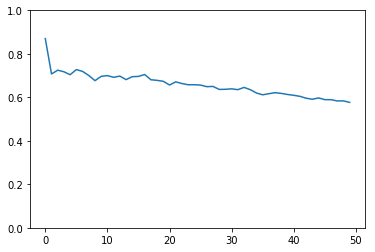

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [19]:
print(np.mean(test_accuracies))

0.6571543635886514


(array([1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        5.000e+00, 5.000e+00, 8.000e+00, 1.700e+01, 1.300e+01, 2.000e+01,
        2.800e+01, 4.600e+01, 5.200e+01, 8.100e+01, 9.400e+01, 9.700e+01,
        1.380e+02, 1.980e+02, 2.320e+02, 2.840e+02, 3.510e+02, 4.340e+02,
        5.420e+02, 6.330e+02, 7.070e+02, 7.310e+02, 8.240e+02, 9.230e+02,
        9.230e+02, 1.031e+03, 9.850e+02, 1.187e+03, 1.148e+03, 1.110e+03,
        1.244e+03, 1.328e+03, 1.330e+03, 1.351e+03, 1.380e+03, 1.352e+03,
        1.363e+03, 1.407e+03, 1.334e+03, 1.345e+03, 1.313e+03, 1.332e+03,
        1.317e+03, 1.288e+03, 1.219e+03, 1.178e+03, 1.145e+03, 1.137e+03,
        1.043e+03, 9.510e+02, 9.990e+02, 9.580e+02, 8.370e+02, 7.770e+02,
        7.030e+02, 6.530e+02, 5.880e+02, 5.490e+02, 4.400e+02, 4.000e+02,
        3.320e+02, 3.110e+02, 2.390e+02, 1.900e+02, 1.810e+02, 1.440e+02,
        1.260e+02, 1.070e+02, 8.800e+01, 6.400e+01, 5.600e+01, 3.200e+01,
        2.300e+01, 1.500e+01, 1.100e+0

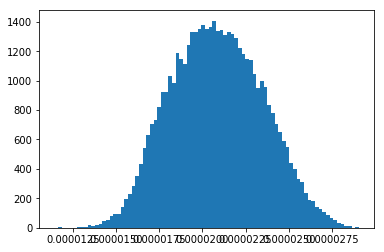

In [21]:
plt.hist(tuner.appended_task_list[-1].train.weights[0 : tuner.appended_task_list[-2].train.weights.shape[0]], bins='auto')

In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()